In [1]:


# coding: utf-8

from __future__ import print_function

import argparse
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import shutil
import time
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from utils import Bar, Logger, AverageMeter, accuracy, mkdir_p, savefig
import numpy as np

from matplotlib import pyplot
from matplotlib.pylab import plt

# from membership_inference_attacks import black_box_benchmarks
from privacy_risk_score_utils import *

In [2]:


from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve

from hop_skip_jump_attack import hop_skip_jump_attack

In [3]:


use_cuda = torch.cuda.is_available()
# torch.cuda.set_device(2)
use_cuda

True

In [4]:


manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
if use_cuda:
    torch.cuda.manual_seed_all(manualSeed)

global best_acc
best_acc = 0  # best test accuracy

In [5]:


# class AlexNet(nn.Module):
#     def __init__(self, num_classes=10):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
#         self.classifier = nn.Linear(256, num_classes)
#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x
    
# def alexnet(**kwargs):
#     r"""AlexNet model architecture from the
#     `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
#     """
#     model = AlexNet(**kwargs)
#     return model

In [6]:


class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.re1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.re2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3,stride=1, padding=1)
        self.re3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3,stride=1, padding=1)
        self.re4 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1)
        self.re5 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
#         )
        
#         self.classifier = nn.Sequential(
        self.d1 = nn.Dropout()
        self.lin1 = nn.Linear(256 * 1 * 1, 4096)
        self.re6 = nn.ReLU(inplace=True)
        self.d2 = nn.Dropout()
        self.lin2 = nn.Linear(4096, 4096)
        self.re7 = nn.ReLU(inplace=True)
        self.lin3 = nn.Linear(4096, num_classes)
#         )
#         self.classifier = nn.Linear(256, num_classes)
    def forward(self, x):
        h1 = self.pool1(self.re1(self.conv1(x)))
        h2 = self.pool2(self.re2(self.conv2(h1)))
        h3 = self.re3(self.conv3(h2))
        h4 = self.re4(self.conv4(h3))
        h5 = self.pool3(self.re5(self.conv5(h4)))
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
        x = torch.flatten(h5, 1)
        h6 = self.re6(self.lin1(self.d1(x)))
        h7 = self.re7(self.lin2(self.d2(h6)))
        output = self.lin3(h7)
                          
        return output, h1, h2, h3, h4, h5, h6, h7

def alexnet(**kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    """
    model = AlexNet(**kwargs)
    return model

In [7]:


class AlexNet_fc(nn.Module):
    def __init__(self, num_classes=10, q = 100, alpha = 1):
        super(AlexNet_fc, self).__init__()
#         self.features = nn.Sequential(
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.re1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.re2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3,stride=1, padding=1)
        self.re3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3,stride=1, padding=1)
        self.re4 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1)
        self.re5 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
#         )
        
#         self.classifier = nn.Sequential(
        self.d1 = nn.Dropout()
        self.lin1 = nn.Linear(256 * 1 * 1, 4096)
        self.re6 = nn.ReLU(inplace=True)
        self.d2 = nn.Dropout()
        self.lin2 = nn.Linear(4096, 4096)
        self.re7 = nn.ReLU(inplace=True)
        self.lin3 = nn.Linear(4096, num_classes)
        
        self.q = q
        self.alpha = alpha
#         )
#         self.classifier = nn.Linear(256, num_classes)

    
    def forward(self, x):
        h1 = self.pool1(self.re1(self.conv1(x)))
        h2 = self.pool2(self.re2(self.conv2(h1)))
        h3 = self.re3(self.conv3(h2))
        h4 = self.re4(self.conv4(h3))
        h5 = self.pool3(self.re5(self.conv5(h4)))
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
        x = torch.flatten(h5, 1)
#         print('self.q: ',self.q, ' self.alpha: ',self.alpha )
#         x = scale_by_percentage(x, q=self.q, alpha = self.alpha)
        h6 = self.re6(self.lin1(self.d1(x)))
        h6 = scale_by_percentage(h6, q=self.q, alpha = self.alpha)
        h7 = self.re7(self.lin2(self.d2(h6)))
        h7 = scale_by_percentage(h7, q=self.q, alpha = self.alpha)
        output = self.lin3(h7)
                          
        return output, h1, h2, h3, h4, h5, h6, h7
    
def scale_by_percentage(x, q=5.0, alpha = 1):
    """
    scale paramters by threshold.

    """
    temp_shape = x.shape
    weight = x.data.cpu().numpy()
    flattened_weights = np.abs(weight.flatten())
#     flattened_weights = np.abs(weight)
#     percentile_value = np.percentile(flattened_weights, q)
    nonzero = flattened_weights[np.nonzero(flattened_weights)]
    percentile_value  = np.percentile(nonzero, q)
    amp = alpha - 1.
    
    tweight = x.data
    new_mask = (tweight >= percentile_value)*amp  + 1.
    
#     mask = np.ones(flattened_weights.shape)
#     new_mask = np.where(flattened_weights >= percentile_value, alpha, mask)

##     new_mask = (flattened_weights >= percentile_value)*amp + 1.

#     new_mask = new_mask.reshape(temp_shape)
#     new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
#     x.data = torch.from_numpy(new_feature_map).cuda()
    x.data  = new_mask * tweight
    return x

        
def alexnet_fc(**kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    """
    model = AlexNet_fc(**kwargs)
    return model

In [8]:


class AlexNet_fc_replace(nn.Module):
    def __init__(self, num_classes=10, q = 100, alpha = 1):
        super(AlexNet_fc_replace, self).__init__()
#         self.features = nn.Sequential(
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.re1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.re2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3,stride=1, padding=1)
        self.re3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3,stride=1, padding=1)
        self.re4 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1)
        self.re5 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
#         )
        
#         self.classifier = nn.Sequential(
        self.d1 = nn.Dropout()
        self.lin1 = nn.Linear(256 * 1 * 1, 4096)
        self.re6 = nn.ReLU(inplace=True)
        self.d2 = nn.Dropout()
        self.lin2 = nn.Linear(4096, 4096)
        self.re7 = nn.ReLU(inplace=True)
        self.lin3 = nn.Linear(4096, num_classes)
        
        self.q = q
        self.alpha = alpha
#         )
#         self.classifier = nn.Linear(256, num_classes)

    
    def forward(self, x):
        h1 = self.pool1(self.re1(self.conv1(x)))
        h2 = self.pool2(self.re2(self.conv2(h1)))
        h3 = self.re3(self.conv3(h2))
        h4 = self.re4(self.conv4(h3))
        h5 = self.pool3(self.re5(self.conv5(h4)))
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
        x = torch.flatten(h5, 1)
#         print('self.q: ',self.q, ' self.alpha: ',self.alpha )
#         x = scale_by_percentage(x, q=self.q, alpha = self.alpha)
        h6 = self.re6(self.lin1(self.d1(x)))
        h6 = scale_by_percentage(h6, q=self.q, alpha = self.alpha)
        h7 = self.re7(self.lin2(self.d2(h6)))
        h7 = scale_by_percentage(h7, q=self.q, alpha = self.alpha)
        output = self.lin3(h7)
                          
        return output, h1, h2, h3, h4, h5, h6, h7

def scale_by_percentage(x, q=5.0, alpha = 1):
    """
    scale paramters by threshold.

    """
    temp_shape = x.shape
    weight = x.data.cpu().numpy()
    flattened_weights = np.abs(weight.flatten())
    percentile_value = np.percentile(flattened_weights, q)
    mask = np.ones(flattened_weights.shape)
#     new_mask = np.where(flattened_weights >= percentile_value, alpha, mask)
    new_mask = np.where(flattened_weights >= percentile_value, alpha, percentile_value)
    new_feature_map = new_mask.reshape(temp_shape)
    new_feature_map = np.asarray(new_feature_map, dtype=np.float32)
    x.data = torch.from_numpy(new_feature_map).cuda()
    return x

        
def alexNet_fc_replace(**kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    """
    model = AlexNet_fc_replace(**kwargs)
    return model

In [9]:


class AlexNet_conv(nn.Module):
    def __init__(self, num_classes=10, q = 100, alpha = 1):
        super(AlexNet_conv, self).__init__()
#         self.features = nn.Sequential(
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.re1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.re2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3,stride=1, padding=1)
        self.re3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3,stride=1, padding=1)
        self.re4 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1)
        self.re5 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
#         )
        
#         self.classifier = nn.Sequential(
        self.d1 = nn.Dropout()
        self.lin1 = nn.Linear(256 * 1 * 1, 4096)
        self.re6 = nn.ReLU(inplace=True)
        self.d2 = nn.Dropout()
        self.lin2 = nn.Linear(4096, 4096)
        self.re7 = nn.ReLU(inplace=True)
        self.lin3 = nn.Linear(4096, num_classes)
        
        self.q = q
        self.alpha = alpha
#         )
#         self.classifier = nn.Linear(256, num_classes)

    
    def forward(self, x):
        h1 = self.pool1(self.re1(self.conv1(x)))
        h1 = scale_by_percentage(h1, q=self.q, alpha = self.alpha)
        h2 = self.pool2(self.re2(self.conv2(h1)))
        h2 = scale_by_percentage(h2, q=self.q, alpha = self.alpha)
        h3 = self.re3(self.conv3(h2))
        h3 = scale_by_percentage(h3, q=self.q, alpha = self.alpha)
        h4 = self.re4(self.conv4(h3))
        h4 = scale_by_percentage(h4, q=self.q, alpha = self.alpha)
        h5 = self.pool3(self.re5(self.conv5(h4)))
#         h5 = scale_by_percentage(h5, q=self.q, alpha = self.alpha)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
        x = torch.flatten(h5, 1)
#         print('self.q: ',self.q, ' self.alpha: ',self.alpha )
        x = scale_by_percentage(x, q=self.q, alpha = self.alpha)
        h6 = self.re6(self.lin1(self.d1(x)))
#         h6 = scale_by_percentage(h6, q=self.q, alpha = self.alpha)
        h7 = self.re7(self.lin2(self.d2(h6)))
#         h7 = scale_by_percentage(h7, q=self.q, alpha = self.alpha)
        output = self.lin3(h7)
                          
        return output, h1, h2, h3, h4, h5, h6, h7

def scale_by_percentage(x, q=5.0, alpha = 1):
    """
    scale paramters by threshold.

    """
    temp_shape = x.shape
    weight = x.data.cpu().numpy()
    flattened_weights = np.abs(weight.flatten())
    nonzero = flattened_weights[np.nonzero(flattened_weights)]
    percentile_value = np.percentile(nonzero, q)
#     percentile_value = np.percentile(flattened_weights, q)
    mask = np.ones(flattened_weights.shape)
    new_mask = np.where(flattened_weights >= percentile_value, alpha, mask)
    new_mask = new_mask.reshape(temp_shape)
    new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
    x.data = torch.from_numpy(new_feature_map).cuda()
    return x

        
def alexnet_conv(**kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    """
    model = AlexNet_conv(**kwargs)
    return model

In [10]:


class AlexNet_comb(nn.Module):
    def __init__(self, num_classes=10, qconv = 100,qfc = 100, aconv = 1, afc = 1):
        super(AlexNet_comb, self).__init__()
#         self.features = nn.Sequential(
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.re1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.re2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3,stride=1, padding=1)
        self.re3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3,stride=1, padding=1)
        self.re4 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1)
        self.re5 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
#         )
        
#         self.classifier = nn.Sequential(
        self.d1 = nn.Dropout()
        self.lin1 = nn.Linear(256 * 1 * 1, 4096)
        self.re6 = nn.ReLU(inplace=True)
        self.d2 = nn.Dropout()
        self.lin2 = nn.Linear(4096, 4096)
        self.re7 = nn.ReLU(inplace=True)
        self.lin3 = nn.Linear(4096, num_classes)
        
        self.qconv = qconv
        self.qfc = qfc
        self.aconv = aconv
        self.afc = afc
#         )
#         self.classifier = nn.Linear(256, num_classes)

    
    def forward(self, x):
        h1 = self.pool1(self.re1(self.conv1(x)))
        h1 = scale_by_percentage(h1, q=self.qconv, alpha = self.aconv)
        h2 = self.pool2(self.re2(self.conv2(h1)))
        h2 = scale_by_percentage(h2, q=self.qconv, alpha = self.aconv)
        h3 = self.re3(self.conv3(h2))
        h3 = scale_by_percentage(h3, q=self.qconv, alpha = self.aconv)
        h4 = self.re4(self.conv4(h3))
        h4 = scale_by_percentage(h4, q=self.qconv, alpha = self.aconv)
        h5 = self.pool3(self.re5(self.conv5(h4)))
#         h5 = scale_by_percentage(h5, q=self.q, alpha = self.alpha)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
        x = torch.flatten(h5, 1)
#         print('self.q: ',self.q, ' self.alpha: ',self.alpha )
        x = scale_by_percentage(x, q=self.qconv, alpha = self.aconv)
#    ========================conv feature map output=================================
        h6 = self.re6(self.lin1(self.d1(x)))
        h6 = scale_by_percentage(h6, q=self.qfc, alpha = self.afc)
        h7 = self.re7(self.lin2(self.d2(h6)))
        h7 = scale_by_percentage(h7, q=self.qfc, alpha = self.afc)
        output = self.lin3(h7)
#    ========================fc feature map output=================================                          
        return output, h1, h2, h3, h4, h5, h6, h7

def scale_by_percentage(x, q=5.0, alpha = 1):
    """
    scale paramters by threshold.

    """
    temp_shape = x.shape
    weight = x.data.cpu().numpy()
    flattened_weights = np.abs(weight.flatten())
    percentile_value = np.percentile(flattened_weights, q)
    mask = np.ones(flattened_weights.shape)
    new_mask = np.where(flattened_weights >= percentile_value, alpha, mask)
    new_mask = new_mask.reshape(temp_shape)
    new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
    x.data = torch.from_numpy(new_feature_map).cuda()
    return x

        
def alexnet_comb(**kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    """
    model = AlexNet_comb(**kwargs)
    return model

In [11]:


class AlexNet_comb_mid(nn.Module):
    def __init__(self, num_classes=10, qconv_l = 100,qconv_h = 100,qfc_l = 100,qfc_h = 100, aconv_l = 1,aconv_h = 1, afc_l = 1, afc_h = 1):
        super(AlexNet_comb_mid, self).__init__()
#         self.features = nn.Sequential(
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.re1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.re2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3,stride=1, padding=1)
        self.re3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3,stride=1, padding=1)
        self.re4 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1)
        self.re5 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
#         )
        
#         self.classifier = nn.Sequential(
        self.d1 = nn.Dropout()
        self.lin1 = nn.Linear(256 * 1 * 1, 4096)
        self.re6 = nn.ReLU(inplace=True)
        self.d2 = nn.Dropout()
        self.lin2 = nn.Linear(4096, 4096)
        self.re7 = nn.ReLU(inplace=True)
        self.lin3 = nn.Linear(4096, num_classes)
        
        self.qconv_l = qconv_l
        self.qconv_h = qconv_h

        self.qfc_l = qfc_l
        self.qfc_h = qfc_h
        
        self.aconv_l = aconv_l
        self.aconv_h = aconv_h
        self.afc_l = afc_l
        self.afc_h= afc_h
#         )
#         self.classifier = nn.Linear(256, num_classes)

    
    def forward(self, x):
        h1 = self.pool1(self.re1(self.conv1(x)))
        h1 = scale_by_percentage_mid(h1, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
        h2 = self.pool2(self.re2(self.conv2(h1)))
        h2 = scale_by_percentage_mid(h2, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
        h3 = self.re3(self.conv3(h2))
        h3 = scale_by_percentage_mid(h3, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
        h4 = self.re4(self.conv4(h3))
        h4 = scale_by_percentage_mid(h4, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
        h5 = self.pool3(self.re5(self.conv5(h4)))
#         h5 = scale_by_percentage(h5, q=self.q, alpha = self.alpha)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
        x = torch.flatten(h5, 1)
#         print('self.q: ',self.q, ' self.alpha: ',self.alpha )
        x = scale_by_percentage_mid(x, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
#    ========================conv feature map output=================================
        h6 = self.re6(self.lin1(self.d1(x)))
        h6 = scale_by_percentage_mid(h6, q_l=self.qfc_l, q_h=self.qfc_h, alpha_l=self.afc_l, alpha_h=self.afc_h)
        h7 = self.re7(self.lin2(self.d2(h6)))
        h7 = scale_by_percentage_mid(h7, q_l=self.qfc_l, q_h=self.qfc_h, alpha_l=self.afc_l, alpha_h=self.afc_h)
        output = self.lin3(h7)
#    ========================fc feature map output=================================                          
        return output, h1, h2, h3, h4, h5, h6, h7

def scale_by_percentage(x, q=5.0, alpha = 1):
    """
    scale paramters by threshold.

    """
    temp_shape = x.shape
    weight = x.data.cpu().numpy()
    flattened_weights = np.abs(weight.flatten())
    percentile_value = np.percentile(flattened_weights, q)
    mask = np.ones(flattened_weights.shape)
    new_mask = np.where(flattened_weights >= percentile_value, alpha, mask)
    new_mask = new_mask.reshape(temp_shape)
    new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
    x.data = torch.from_numpy(new_feature_map).cuda()
    return x

def scale_by_percentage_mid(x, q_l=100, q_h=100, alpha_l=1, alpha_h=1):
    """
    scale paramters by threshold.

    """
    # print('q_l: ', q_l, 'q_h: ', q_h)
    temp_shape = x.shape
    weight = x.data.cpu().numpy()
    flattened_weights = np.abs(weight.flatten())
    nonzero = flattened_weights[np.nonzero(flattened_weights)]
    p_value_low = np.percentile(nonzero, q_l)
    p_value_high = np.percentile(nonzero, q_h)
    # print('p_value_low: ', p_value_low, 'p_value_high: ',p_value_high)
    mask = np.ones(flattened_weights.shape)
    new_mask = np.where(flattened_weights >= p_value_low, alpha_l, mask)
    # print(new_mask)
    new_mask = np.where(flattened_weights >= p_value_high, alpha_h, new_mask)
    # print(new_mask)
    new_mask = new_mask.reshape(temp_shape)

    new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
    x.data = torch.from_numpy(new_feature_map).cuda()
    return x


# def scale_by_percentage_mid(x, q_l = 50, q_h = 90, alpha_l = 1, alpha_h = 1):
#     """
#     scale paramters by threshold.

#     """
# #     print('q_l: ', q_l, 'q_h: ', q_h)
#     temp_shape = x.shape
#     weight = x.data.cpu().numpy()
#     flattened_weights = np.abs(weight.flatten())
#     p_value_low = np.percentile(flattened_weights, q_l)
#     p_value_high = np.percentile(flattened_weights, q_h)
# #     print('p_value_low: ', p_value_low, 'p_value_high: ',p_value_high)
#     mask = np.ones(flattened_weights.shape)
#     new_mask = np.where(flattened_weights >= p_value_low, alpha_l, mask)
# #     print(new_mask)
#     new_mask = np.where(flattened_weights >= p_value_high, alpha_h, new_mask)
# #     print(new_mask)
#     new_mask = new_mask.reshape(temp_shape)
    
#     new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
#     x.data = torch.from_numpy(new_feature_map).cuda()
#     return x
        
def alexnet_comb_mid(**kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    """
    model = AlexNet_comb_mid(**kwargs)
    return model

In [12]:


class AlexNet_comb_rand(nn.Module):
    def __init__(self, num_classes=10, qconv_l = 100,qconv_h = 100,qfc_l = 100,qfc_h = 100, aconv_l = 1,aconv_h = 1, afc_l = 1, afc_h = 1):
        super(AlexNet_comb_rand, self).__init__()
#         self.features = nn.Sequential(
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.re1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.re2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3,stride=1, padding=1)
        self.re3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3,stride=1, padding=1)
        self.re4 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1)
        self.re5 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
#         )
        
#         self.classifier = nn.Sequential(
        self.d1 = nn.Dropout()
        self.lin1 = nn.Linear(256 * 1 * 1, 4096)
        self.re6 = nn.ReLU(inplace=True)
        self.d2 = nn.Dropout()
        self.lin2 = nn.Linear(4096, 4096)
        self.re7 = nn.ReLU(inplace=True)
        self.lin3 = nn.Linear(4096, num_classes)
        
        self.qconv_l = qconv_l
        self.qconv_h = qconv_h

        self.qfc_l = qfc_l
        self.qfc_h = qfc_h
        
        self.aconv_l = aconv_l
        self.aconv_h = aconv_h
        self.afc_l = afc_l
        self.afc_h= afc_h
#         )
#         self.classifier = nn.Linear(256, num_classes)

    
    def forward(self, x):
        h1 = self.pool1(self.re1(self.conv1(x)))
        h1 = scale_by_percentage_mid(h1, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
        h2 = self.pool2(self.re2(self.conv2(h1)))
        h2 = scale_by_percentage_mid(h2, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
        h3 = self.re3(self.conv3(h2))
        h3 = scale_by_percentage_mid(h3, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
        h4 = self.re4(self.conv4(h3))
        h4 = scale_by_percentage_mid(h4, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
        h5 = self.pool3(self.re5(self.conv5(h4)))
#         h5 = scale_by_percentage(h5, q=self.q, alpha = self.alpha)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
        x = torch.flatten(h5, 1)
#         print('self.q: ',self.q, ' self.alpha: ',self.alpha )
        x = scale_by_percentage_mid(x, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
    
#    ========================conv feature map output=================================
        h6 = self.re6(self.lin1(self.d1(x)))
#         h6 = scale_by_percentage_mid(h6, q_l=self.qfc_l, q_h=self.qfc_h, alpha_l=self.afc_l, alpha_h=self.afc_h)
        h6 = scale_rand(h6)
        h7 = self.re7(self.lin2(self.d2(h6)))
#         h7 = scale_by_percentage_mid(h7, q_l=self.qfc_l, q_h=self.qfc_h, alpha_l=self.afc_l, alpha_h=self.afc_h)
        h7 = scale_rand(h7)
        output = self.lin3(h7)
#    ========================fc feature map output=================================                          
        return output, h1, h2, h3, h4, h5, h6, h7

def scale_by_percentage(x, q=5.0, alpha = 1):
    """
    scale paramters by threshold.

    """
    temp_shape = x.shape
    weight = x.data.cpu().numpy()
    flattened_weights = np.abs(weight.flatten())
    percentile_value = np.percentile(flattened_weights, q)
    mask = np.ones(flattened_weights.shape)
    new_mask = np.where(flattened_weights >= percentile_value, alpha, mask)
    new_mask = new_mask.reshape(temp_shape)
    new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
    x.data = torch.from_numpy(new_feature_map).cuda()
    return x

def scale_rand(x):
    """
    scale paramters by threshold.

    """
#     temp_shape = x.shape
    rand = torch.rand(x.size()).cuda() + 0.5
    x = x * rand
#     weight = x.data.cpu().numpy()
#     flattened_weights = np.abs(weight.flatten())
#     percentile_value = np.percentile(flattened_weights, q)
#     mask = np.ones(flattened_weights.shape)
#     new_mask = np.where(flattened_weights >= percentile_value, alpha, mask)
#     new_mask = new_mask.reshape(temp_shape)
#     new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
#     x.data = torch.from_numpy(new_feature_map).cuda()
    return x

def scale_by_percentage_mid(x, q_l = 50, q_h = 90, alpha_l = 1, alpha_h = 1):
    """
    scale paramters by threshold.

    """
#     print('q_l: ', q_l, 'q_h: ', q_h)
    temp_shape = x.shape
    weight = x.data.cpu().numpy()
    flattened_weights = np.abs(weight.flatten())
    p_value_low = np.percentile(flattened_weights, q_l)
    p_value_high = np.percentile(flattened_weights, q_h)
#     print('p_value_low: ', p_value_low, 'p_value_high: ',p_value_high)
    mask = np.ones(flattened_weights.shape)
    new_mask = np.where(flattened_weights >= p_value_low, alpha_l, mask)
#     print(new_mask)
    new_mask = np.where(flattened_weights >= p_value_high, alpha_h, new_mask)
#     print(new_mask)
    new_mask = new_mask.reshape(temp_shape)
    
    new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
    x.data = torch.from_numpy(new_feature_map).cuda()
    return x
        
def alexnet_comb_rand(**kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    """
    model = AlexNet_comb_rand(**kwargs)
    return model

In [13]:


class AlexNet_comb_rand_mod1(nn.Module):
    def __init__(self, num_classes=10, qconv_l = 100,qconv_h = 100,qfc_l = 100,qfc_h = 100, aconv_l = 1,aconv_h = 1, afc_l = 1, afc_h = 1):
        super(AlexNet_comb_rand_mod1, self).__init__()
#         self.features = nn.Sequential(
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.re1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.re2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3,stride=1, padding=1)
        self.re3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3,stride=1, padding=1)
        self.re4 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1)
        self.re5 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
#         )
        
#         self.classifier = nn.Sequential(
        self.d1 = nn.Dropout()
        self.lin1 = nn.Linear(256 * 1 * 1, 4096)
        self.re6 = nn.ReLU(inplace=True)
        self.d2 = nn.Dropout()
        self.lin2 = nn.Linear(4096, 4096)
        self.re7 = nn.ReLU(inplace=True)
        self.lin3 = nn.Linear(4096, num_classes)
        
        self.qconv_l = qconv_l
        self.qconv_h = qconv_h

        self.qfc_l = qfc_l
        self.qfc_h = qfc_h
        
        self.aconv_l = aconv_l
        self.aconv_h = aconv_h
        self.afc_l = afc_l
        self.afc_h= afc_h
#         )
#         self.classifier = nn.Linear(256, num_classes)

    
    def forward(self, x):
        h1 = self.pool1(self.re1(self.conv1(x)))
        h1 = scale_by_percentage_mid(h1, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
        h2 = self.pool2(self.re2(self.conv2(h1)))
        h2 = scale_by_percentage_mid(h2, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
        h3 = self.re3(self.conv3(h2))
        h3 = scale_by_percentage_mid(h3, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
        h4 = self.re4(self.conv4(h3))
        h4 = scale_by_percentage_mid(h4, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
        h5 = self.pool3(self.re5(self.conv5(h4)))
#         h5 = scale_by_percentage(h5, q=self.q, alpha = self.alpha)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
        x = torch.flatten(h5, 1)
#         print('self.q: ',self.q, ' self.alpha: ',self.alpha )
#         x = scale_by_percentage_mid(x, q_l=self.qconv_l, q_h=self.qconv_h, alpha_l = self.aconv_l, alpha_h = self.aconv_h)
        x = scale_rand(x)
#    ========================conv feature map output=================================
        h6 = self.re6(self.lin1(self.d1(x)))
#         h6 = scale_by_percentage_mid(h6, q_l=self.qfc_l, q_h=self.qfc_h, alpha_l=self.afc_l, alpha_h=self.afc_h)
        h6 = scale_rand(h6)
        h7 = self.re7(self.lin2(self.d2(h6)))
#         h7 = scale_by_percentage_mid(h7, q_l=self.qfc_l, q_h=self.qfc_h, alpha_l=self.afc_l, alpha_h=self.afc_h)
        h7 = scale_rand(h7)
        output = self.lin3(h7)
#    ========================fc feature map output=================================                          
        return output, h1, h2, h3, h4, h5, h6, h7

def scale_by_percentage(x, q=5.0, alpha = 1):
    """
    scale paramters by threshold.

    """
    temp_shape = x.shape
    weight = x.data.cpu().numpy()
    flattened_weights = np.abs(weight.flatten())
    percentile_value = np.percentile(flattened_weights, q)
    mask = np.ones(flattened_weights.shape)
    new_mask = np.where(flattened_weights >= percentile_value, alpha, mask)
    new_mask = new_mask.reshape(temp_shape)
    new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
    x.data = torch.from_numpy(new_feature_map).cuda()
    return x

def scale_rand(x):
    """
    scale paramters by threshold.

    """
#     temp_shape = x.shape
    rand = torch.rand(x.size()).cuda() + 0.5
    x = x * rand
#     weight = x.data.cpu().numpy()
#     flattened_weights = np.abs(weight.flatten())
#     percentile_value = np.percentile(flattened_weights, q)
#     mask = np.ones(flattened_weights.shape)
#     new_mask = np.where(flattened_weights >= percentile_value, alpha, mask)
#     new_mask = new_mask.reshape(temp_shape)
#     new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
#     x.data = torch.from_numpy(new_feature_map).cuda()
    return x

def scale_by_percentage_mid(x, q_l = 50, q_h = 90, alpha_l = 1, alpha_h = 1):
    """
    scale paramters by threshold.

    """
#     print('q_l: ', q_l, 'q_h: ', q_h)
    temp_shape = x.shape
    weight = x.data.cpu().numpy()
    flattened_weights = np.abs(weight.flatten())
    p_value_low = np.percentile(flattened_weights, q_l)
    p_value_high = np.percentile(flattened_weights, q_h)
#     print('p_value_low: ', p_value_low, 'p_value_high: ',p_value_high)
    mask = np.ones(flattened_weights.shape)
    new_mask = np.where(flattened_weights >= p_value_low, alpha_l, mask)
#     print(new_mask)
    new_mask = np.where(flattened_weights >= p_value_high, alpha_h, new_mask)
#     print(new_mask)
    new_mask = new_mask.reshape(temp_shape)
    
    new_feature_map = np.asarray(weight * new_mask, dtype=np.float32)
    x.data = torch.from_numpy(new_feature_map).cuda()
    return x
        
def alexnet_comb_rand_mod1(**kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    """
    model = AlexNet_comb_rand_mod1(**kwargs)
    return model

In [14]:


class AlexNet_mod(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet_mod, self).__init__()
#         self.features = nn.Sequential(
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.re1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.re2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3,stride=1, padding=1)
        self.re3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3,stride=1, padding=1)
        self.re4 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1)
        self.re5 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.lin4 = nn.Linear(256*1*1, 10)
#         )
        
#         self.classifier = nn.Sequential(
        self.d1 = nn.Dropout()
        self.lin1 = nn.Linear(256 * 1 * 1, 4096)
        self.re6 = nn.ReLU(inplace=True)
        self.d2 = nn.Dropout()
        self.lin2 = nn.Linear(4096, 4096)
        self.re7 = nn.ReLU(inplace=True)
        self.lin3 = nn.Linear(4096, num_classes)
#         )
#         self.classifier = nn.Linear(256, num_classes)
    def forward(self, x):
        h1 = self.pool1(self.re1(self.conv1(x)))
        h2 = self.pool2(self.re2(self.conv2(h1)))
        h3 = self.re3(self.conv3(h2))
        h4 = self.re4(self.conv4(h3))
        h5 = self.pool3(self.re5(self.conv5(h4)))
        out_h5 = self.lin4(torch.flatten(h5, 1))
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
        x = torch.flatten(h5, 1)
        h6 = self.re6(self.lin1(self.d1(x)))
        h7 = self.re7(self.lin2(self.d2(h6)))
        output = self.lin3(h7)
                          
        return output, h1, h2, h3, h4, h5, h6, h7, out_h5

def alexnet_mod(**kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    """
    model = AlexNet_mod(**kwargs)
    return model

In [15]:


class InferenceAttack_HZ(nn.Module):
    def __init__(self,num_classes):
        self.num_classes=num_classes
        super(InferenceAttack_HZ, self).__init__()
        self.features=nn.Sequential(
            nn.Linear(num_classes,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,64),
            nn.ReLU(),
            )
        self.labels=nn.Sequential(
#            nn.Linear(num_classes,128),
#             nn.ReLU(),
#             nn.Linear(128,64),
#             nn.ReLU(),
#             )
            nn.Linear(num_classes,512),
            nn.ReLU(),
            nn.Linear(512,64),
            nn.ReLU(),
            )
        self.combine=nn.Sequential(
#             nn.Linear(64*2,256),
            nn.Linear(64*2,512),
            
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,1),
            )
        for key in self.state_dict():
            print (key)
            if key.split('.')[-1] == 'weight':    
                nn.init.normal(self.state_dict()[key], std=0.01)
                print (key)
                
            elif key.split('.')[-1] == 'bias':
                self.state_dict()[key][...] = 0
        self.output= nn.Sigmoid()
    def forward(self,x,l):
        
        out_x = self.features(x)
        out_l = self.labels(l)
        

        is_member =self.combine( torch.cat((out_x  ,out_l),1))
        
        
        return self.output(is_member)

In [16]:


# defense model
class Defense_Model(nn.Module):
    def __init__(self, num_classes=1):
        super(Defense_Model, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(num_classes, 256),

            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
        self.output = nn.Sigmoid()

    def forward(self, x):
        is_member = self.features(x)
        return self.output(is_member), is_member

In [17]:


def train_privatly(trainloader, model,inference_model, criterion, optimizer, epoch, use_cuda,num_batchs=10000,alpha=0.9):
    # switch to train mode
    model.train()
    inference_model.eval()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    end = time.time()
    
    first_id = -1
    for batch_idx, (inputs, targets) in (trainloader):
        # measure data loading time
        data_time.update(time.time() - end)
        if first_id == -1:
            first_id = batch_idx
        
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        
        
        one_hot_tr = torch.from_numpy((np.zeros((outputs.size(0),100))-1)).cuda().type(torch.cuda.FloatTensor)
        target_one_hot_tr = one_hot_tr.scatter_(1, targets.type(torch.cuda.LongTensor).view([-1,1]).data,1)
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
        
        inference_output = inference_model ( outputs,infer_input_one_hot)
        #print (inference_output.mean())
        
#         loss = criterion(outputs, targets) + (alpha)*(((inference_output-1.0).pow(2).mean()))
        loss = criterion(outputs, targets) + (alpha)*(((inference_output-0.5).pow(2).mean()))

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
#         losses.update(loss.data[0], inputs.size(0))
        losses.update(loss.data, inputs.size(0))
        top1.update(prec1, inputs.size(0))
        top5.update(prec5, inputs.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if batch_idx%100==0:
            print  ('modeltrain--({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                    batch=batch_idx + 1,
                    size=500,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    top5=top5.avg,
                    ))
        if batch_idx-first_id >= num_batchs:
            break
    return (losses.avg, top1.avg)

In [21]:


def train(trainloader, model, criterion, optimizer, epoch, use_cuda):
    # switch to train mode
    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    end = time.time()
    bar = Bar('Processing', max=len(trainloader))
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # measure data loading time
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
#         outputs,_,_,_,_,_,_,_,_ = model(inputs)
        outputs,_,_,_,_,_,_,_ = model(inputs)
#         outputs = model(inputs)
#         print(outputs.shape)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
#         losses.update(loss.data[0], inputs.size(0))
        losses.update(loss.data, inputs.size(0))
        top1.update(prec1, inputs.size(0))
        top5.update(prec5, inputs.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if batch_idx%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    top5=top5.avg,
                    ))
    return (losses.avg, top1.avg)

In [22]:


def test(testloader, model, criterion, epoch, use_cuda):
    global best_acc
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()
    end = time.time()
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # measure data loading time
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

        # compute output
#         outputs,_,_,_,_,_,_,_,_ = model(inputs)
        outputs,_,_,_,_,_,_,_ = model(inputs)
#         outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
#         losses.update(loss.data[0], inputs.size(0))
        losses.update(loss.data, inputs.size(0))
        top1.update(prec1, inputs.size(0))
        top5.update(prec5, inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if batch_idx % 20==0:
            
            print ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(testloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        ))
    return (losses.avg, top1.avg)

In [23]:


def test_by_class(testloader, model, criterion, epoch, use_cuda):
    global best_acc
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()
    end = time.time()
    class_count = np.zeros(100)
    class_correct = np.zeros(100)
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # measure data loading time
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

        # compute output
#         outputs,_,_,_,_,_,_,_,_ = model(inputs)
        outputs,_,_,_,_,_,_,_ = model(inputs)
#         outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        _, pred = outputs.topk(1, 1, True, True)
        pred = pred.t()
        correct = pred.eq(targets.view(1, -1).expand_as(pred))
        correct = correct.data.cpu().numpy()
        targets = targets.data.cpu().numpy()
        for i in range(len(targets)):
            class_count[targets[i]] += 1
            class_correct[targets[i]] += correct[0,i]
#         losses.update(loss.data[0], inputs.size(0))
        losses.update(loss.data, inputs.size(0))
        top1.update(prec1, inputs.size(0))
        top5.update(prec5, inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if batch_idx % 20==0:
            
            print ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(testloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        ))
    return (losses.avg, top1.avg, class_count, class_correct)

In [24]:


def train_one(trainloader, model, criterion, optimizer, epoch, use_cuda):
    # switch to train mode
    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    end = time.time()
    bar = Bar('Processing', max=len(trainloader))
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # measure data loading time
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
#         print(outputs.shape)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
#         losses.update(loss.data[0], inputs.size(0))
        losses.update(loss.data, inputs.size(0))
        top1.update(prec1, inputs.size(0))
        top5.update(prec5, inputs.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if batch_idx%100==0:
            print  ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    top5=top5.avg,
                    ))
    return (losses.avg, top1.avg)

In [25]:


def test_one(testloader, model, criterion, epoch, use_cuda):
    global best_acc
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()
    end = time.time()
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # measure data loading time
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

        # compute output
#         outputs,_,_,_,_,_,_,_,_ = model(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
#         losses.update(loss.data[0], inputs.size(0))
        losses.update(loss.data, inputs.size(0))
        top1.update(prec1, inputs.size(0))
        top5.update(prec5, inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if batch_idx % 20==0:
            
            print ('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Loss: {loss:.4f} | top1: {top1: .4f} | top5: {top5: .4f}'.format(
                        batch=batch_idx + 1,
                        size=len(testloader),
                        data=data_time.avg,
                        bt=batch_time.avg,
                        loss=losses.avg,
                        top1=top1.avg,
                        top5=top5.avg,
                        ))
    return (losses.avg, top1.avg)

In [31]:


def train_half_diff_fc_min_var(trainloader, model, criterion, optimizer, mean_class,var_n, epoch, use_cuda,num_class=100, alpha = 1.0, beta = 1.0):
    # switch to train mode
    model.train()
    softmax = nn.Softmax()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    losses_var = AverageMeter()
    losses_diff = AverageMeter()
    max_train_outputs = AverageMeter()
    min_train_outputs = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    print('alpha: ', alpha, ' beta: ',beta)
    end = time.time()
#     len_t =  (len(train_data)//batch_size)
    
#     mean_class = torch.from_numpy(np.zeros((num_class,num_class))).cuda().type(torch.cuda.FloatTensor)
#     mean_class = np.zeros((num_class,num_class))
#     var_n = np.zeros(num_class)
#     mean_var = torch.from_numpy(np.zeros((num_class))).cuda().type(torch.cuda.FloatTensor)
#     mean_var = np.zeros((num_class))
 
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # measure data loading time
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs,h1,h2,h3,h4,h5,h6,h7  = model(inputs)
        
#         fh1 = torch.sum(torch.sum(h1,2),2)
#         fh2 = torch.sum(torch.sum(h2,2),2)
#         fh3 = torch.sum(torch.sum(h3,2),2)
#         fh4 = torch.sum(torch.sum(h4,2),2)
#         fh5 = torch.sum(torch.sum(h5,2),2)
        
        out_list = [h6, h7, outputs]
        sum_diff = torch.zeros(out_list[0].shape[0]).cuda()
        for out_layer in out_list:

            # hidden_outputs.shape
            hidden_map = torch.ones(out_layer.shape[1]).cuda()
            hidden_map[out_layer.shape[1]//2:] = -1
        #     torch.sum(hidden_map)
            hd_diff_map = out_layer * hidden_map
            # hd_diff_map.shape
            hd_diff = torch.sum(hd_diff_map, 1)
            var_hd = hd_diff ** 2 / hd_diff_map.shape[1]
            sum_diff += var_hd
        
        diff_var = sum_diff.mean() * alpha
        
        soft_outputs = softmax(outputs)
        max_outputs = torch.max(soft_outputs,1).values
        min_outputs = torch.min(max_outputs)
        
#         mean_outputs = torch.mean(soft_outputs,0)
#         var = -torch.mean(torch.sum((soft_outputs - mean_outputs).pow(2),1))

        for i in range(inputs.size(0)):
#         var_n[targets[i]] = var_n[targets[i]] + 1
            var_n[targets[i]] += 1
    #         mean_class[targets[i]] = mean_class[targets[i]]*(var_n[targets[i]]-1)/var_n[targets[i]] + soft_outputs[i]/var_n[targets[i]]
            mean_class[targets[i]] = mean_class[targets[i]]*(var_n[targets[i]]-1)/var_n[targets[i]] + soft_outputs[i].data.cpu().numpy()/var_n[targets[i]]
    #         mean_var[targets[i]] = mean_var[targets[i]]*(var_n[targets[i]]-1)/var_n[targets[i]] + torch.sum((soft_outputs[i] - mean_class[targets[i]]).pow(2))/var_n[targets[i]]
    #         mean_var[targets[i]] = mean_var[targets[i]]*(var_n[targets[i]]-1)/var_n[targets[i]] + torch.sum((soft_outputs[i] - torch.from_numpy(mean_class[targets[i]]).cuda()).pow(2))/var_n[targets[i]]

        temp_mean = torch.from_numpy(mean_class).cuda()
#         mean_var = torch.sum((soft_outputs - temp_mean[targets]).pow(2))
        mean_var = torch.sum((soft_outputs - temp_mean[targets]).pow(2),1)
    
        var = torch.mean(mean_var)*beta
#         var = -mean_var * alpha

# #         sort_mean_class,_ = torch.sort(temp_mean)
# #         sort_mean_output = torch.mean(sort_mean_class,0)
#         sort_soft_outputs,_ = torch.sort(soft_outputs)
        
        
# #         sort_var = torch.sum((sort_soft_outputs - sort_mean_output).pow(2),1)
# #         var = torch.mean(sort_var) * beta
        
# #         sort_var = torch.sum((sort_soft_outputs - sort_mean_class[targets]).pow(2),1)
# #         var = torch.mean(sort_var)*beta

# #         sort_var = torch.sum((sort_soft_outputs - sort_mean_output).pow(2))
# #         var = sort_var * beta

# #         s_var = sort_var * beta
# #         sort_mean_low8 = torch.mean(sort_soft_outputs[:,:8],1).view(-1,1)
# #         sort_mean_low8 = sort_mean_low8.expand(-1, 8)
        
# #         low8_var = torch.sum((sort_soft_outputs[:,:8] - sort_mean_low8).pow(2),1)
# #         low8_loss = -torch.mean(low8_var) * alpha
#         sort_diff_top = sort_soft_outputs[:,9] - sort_soft_outputs[:,8]
#         diff_top = torch.mean(sort_diff_top) * alpha
#     #         var = -torch.mean(torch.from_numpy(mean_var)).cuda()*alpha
#     #         var = torch.autograd.Variable(var)
    
#         sort_soft_outputs_mean = torch.mean(sort_soft_outputs,0)
# #         mean_diff = torch.abs(torch.sum(sort_soft_outputs_mean[99]) - torch.sum(sort_soft_outputs_mean[:99]))
# #         mean_diff = torch.abs(sort_soft_outputs_mean[99] - 0.6)
#         mean_diff = torch.mean(torch.sum(sort_soft_outputs[:,5:],1) - torch.sum(sort_soft_outputs[:,:5],1))
#         loss_diff = beta * mean_diff
        
        loss = criterion(outputs, targets) + var + diff_var
        
#         loss = criterion(outputs, targets)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(outputs.data, targets.data, topk=(1, 5))
        losses.update(loss.data, inputs.size()[0])
        losses_var.update(var.data, inputs.size()[0])
        losses_diff.update(diff_var.data, inputs.size()[0])
        top1.update(prec1, inputs.size()[0])
        top5.update(prec5, inputs.size()[0])
        max_train_outputs.update(torch.mean(max_outputs), inputs.size()[0])
        min_train_outputs.update(min_outputs, inputs.size()[0])
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward() #retain_graph=True)
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if batch_idx%100==0:
            print  ('({batch}/{size}) |Batch: {bt:.3f}s| Loss: {loss:.4f} |var: {loss_var:.4f} | diff_top: {loss_d:.4f} | Max: {tmax:.4f} | Min: {tmin:.4f}| top1: {top1: .4f} | top5: {top5: .4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    bt=batch_time.avg,
                    loss=losses.avg,
                    loss_var=losses_var.avg,
                    loss_d=losses_diff.avg,
                    tmax = max_train_outputs.avg,
                    tmin = min_train_outputs.avg,
                    top1=top1.avg,
                    top5=top5.avg,
                    ))
    return (losses.avg,losses_var.avg, losses_diff.avg,top1.avg)
        


In [34]:


def privacy_train(trainloader, model,inference_model, criterion, optimizer, epoch, use_cuda,num_batchs=1000):
    global best_acc
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    mtop1_a = AverageMeter()
    mtop5_a = AverageMeter()
    
    inference_model.train()
    model.eval()
    # switch to evaluate mode
    end = time.time()
    first_id = -1
    for batch_idx,((tr_input, tr_target) ,(te_input, te_target)) in trainloader:
        # measure data loading time
        if first_id == -1:
            first_id = batch_idx
        
        data_time.update(time.time() - end)
        tr_input = tr_input.cuda()
        te_input = te_input.cuda()
        tr_target = tr_target.cuda()
        te_target = te_target.cuda()
        
        
        v_tr_input = torch.autograd.Variable(tr_input)
        v_te_input = torch.autograd.Variable(te_input)
        v_tr_target = torch.autograd.Variable(tr_target)
        v_te_target = torch.autograd.Variable(te_target)
        
        # compute output
        model_input =torch.cat((v_tr_input,v_te_input))
        
        pred_outputs,_,_,_,_,_,_,_,_  = model(model_input)
        
        infer_input= torch.cat((v_tr_target,v_te_target))
        
        mtop1, mtop5 =accuracy(pred_outputs.data, infer_input.data, topk=(1, 5))
        
        mtop1_a.update(mtop1, model_input.size(0))
        mtop5_a.update(mtop5, model_input.size(0))
        
        
        one_hot_tr = torch.from_numpy((np.zeros((infer_input.size(0),10))-1)).cuda().type(torch.cuda.FloatTensor)
        target_one_hot_tr = one_hot_tr.scatter_(1, infer_input.type(torch.cuda.LongTensor).view([-1,1]).data,1)
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
        
        attack_model_input = pred_outputs #torch.cat((pred_outputs,infer_input_one_hot),1)
        member_output = inference_model(attack_model_input,infer_input_one_hot)
        
#         is_member_labels = torch.from_numpy(np.reshape(np.concatenate((np.zeros(v_tr_input.size(0)),np.ones(v_te_input.size(0)))),[-1,1])).cuda()
        is_member_labels = torch.from_numpy(np.reshape(np.concatenate((np.ones(v_tr_input.size(0)),np.zeros(v_te_input.size(0)))),[-1,1])).cuda()

        v_is_member_labels = torch.autograd.Variable(is_member_labels).type(torch.cuda.FloatTensor)
        loss = criterion(member_output, v_is_member_labels)

        # measure accuracy and record loss
        prec1=np.mean((member_output.data.cpu().numpy() >0.5)==v_is_member_labels.data.cpu().numpy())
        losses.update(loss.data, model_input.size(0))
        top1.update(prec1, model_input.size(0))
        
#         print ( "member_output: " ,member_output.data.cpu().numpy())
#         print("v_is_member_labels: ",v_is_member_labels.data.cpu().numpy())
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if batch_idx-first_id > num_batchs:
            break

        # plot progress
        if batch_idx%10==0:
            print  ('attack_train--({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=batch_idx ,
                    size=100,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
    return (losses.avg, top1.avg)

In [35]:


def privacy_test(trainloader, model, inference_model, criterion, optimizer, epoch, use_cuda,num_batchs=1000):
    global best_acc
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    mtop1_a = AverageMeter()
    mtop5_a = AverageMeter()
    first_id = -1
    inference_model.eval()
    model.eval()
    # switch to evaluate mode
    end = time.time()
    for batch_idx,((tr_input, tr_target) ,(te_input, te_target)) in trainloader:
        # measure data loading time
        if first_id == -1:
            first_id = batch_idx
        data_time.update(time.time() - end)
        tr_input = tr_input.cuda()
        te_input = te_input.cuda()
        tr_target = tr_target.cuda()
        te_target = te_target.cuda()
        
        
        v_tr_input = torch.autograd.Variable(tr_input)
        v_te_input = torch.autograd.Variable(te_input)
        v_tr_target = torch.autograd.Variable(tr_target)
        v_te_target = torch.autograd.Variable(te_target)
        
        # compute output
        model_input =torch.cat((v_tr_input,v_te_input))
        
        pred_outputs ,_,_,_,_,_,_,_,_ = model(model_input)
        
        infer_input= torch.cat((v_tr_target,v_te_target))
        
        mtop1, mtop5 =accuracy(pred_outputs.data, infer_input.data, topk=(1, 5))
        
        mtop1_a.update(mtop1, model_input.size(0))
        mtop5_a.update(mtop5, model_input.size(0))
        
        
        one_hot_tr = torch.from_numpy((np.zeros((infer_input.size(0),10))-1)).cuda().type(torch.cuda.FloatTensor)
        target_one_hot_tr = one_hot_tr.scatter_(1, infer_input.type(torch.cuda.LongTensor).view([-1,1]).data,1)
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
        
        attack_model_input = pred_outputs#torch.cat((pred_outputs,infer_input_one_hot),1)
        member_output = inference_model(attack_model_input,infer_input_one_hot)
        
        
#         is_member_labels = torch.from_numpy(np.reshape(np.concatenate((np.zeros(v_tr_input.size(0)),np.ones(v_te_input.size(0)))),[-1,1])).cuda()
        is_member_labels = torch.from_numpy(np.reshape(np.concatenate((np.ones(v_tr_input.size(0)),np.zeros(v_te_input.size(0)))),[-1,1])).cuda()
        
        v_is_member_labels = torch.autograd.Variable(is_member_labels).type(torch.cuda.FloatTensor)
        loss = criterion(member_output, v_is_member_labels)

        # measure accuracy and record loss
        prec1=np.mean((member_output.data.cpu().numpy() >0.5)==v_is_member_labels.data.cpu().numpy())
        losses.update(loss.data, model_input.size(0))
        top1.update(prec1, model_input.size(0))

        # compute gradient and do SGD step
        
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if batch_idx-first_id > num_batchs:
            break

#         plot progress
        if batch_idx%10==0:
            print  ('privacy_test--({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=batch_idx ,
                    size=100,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
            if epoch == 9:
                print ( "member_output: " ,member_output.data.cpu().numpy())
                print("v_is_member_labels: ",v_is_member_labels.data.cpu().numpy())
    return (losses.avg, top1.avg)

In [36]:


def privacy_train_softmax(trainloader, model,inference_model, criterion, optimizer, epoch, use_cuda,num_batchs=1000):
    global best_acc
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    mtop1_a = AverageMeter()
    mtop5_a = AverageMeter()
    
    softmax = nn.Softmax()
    
    inference_model.train()
    model.eval()
    # switch to evaluate mode
    end = time.time()
    first_id = -1
    for batch_idx,((tr_input, tr_target) ,(te_input, te_target)) in trainloader:
        # measure data loading time
        if first_id == -1:
            first_id = batch_idx
        
        data_time.update(time.time() - end)
        tr_input = tr_input.cuda()
        te_input = te_input.cuda()
        tr_target = tr_target.cuda()
        te_target = te_target.cuda()
        
        
        v_tr_input = torch.autograd.Variable(tr_input)
        v_te_input = torch.autograd.Variable(te_input)
        v_tr_target = torch.autograd.Variable(tr_target)
        v_te_target = torch.autograd.Variable(te_target)
        
        # compute output
        model_input =torch.cat((v_tr_input,v_te_input))
        
        pred_outputs,_,_,_,_,_,_,_  = model(model_input)
#         pred_outputs = model(model_input)
        
        infer_input= torch.cat((v_tr_target,v_te_target))
        
        mtop1, mtop5 =accuracy(pred_outputs.data, infer_input.data, topk=(1, 5))
        
        mtop1_a.update(mtop1, model_input.size(0))
        mtop5_a.update(mtop5, model_input.size(0))
        
        
        one_hot_tr = torch.from_numpy((np.zeros((infer_input.size(0),pred_outputs.size(1)))-1)).cuda().type(torch.cuda.FloatTensor)
        target_one_hot_tr = one_hot_tr.scatter_(1, infer_input.type(torch.cuda.LongTensor).view([-1,1]).data,1)
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
        
        attack_model_input = softmax(pred_outputs) #torch.cat((pred_outputs,infer_input_one_hot),1)
#         print(attack_model_input.shape, infer_input_one_hot.shape)
        member_output = inference_model(attack_model_input,infer_input_one_hot)
        
#         is_member_labels = torch.from_numpy(np.reshape(np.concatenate((np.zeros(v_tr_input.size(0)),np.ones(v_te_input.size(0)))),[-1,1])).cuda()
        is_member_labels = torch.from_numpy(np.reshape(np.concatenate((np.ones(v_tr_input.size(0)),np.zeros(v_te_input.size(0)))),[-1,1])).cuda()

        v_is_member_labels = torch.autograd.Variable(is_member_labels).type(torch.cuda.FloatTensor)
        loss = criterion(member_output, v_is_member_labels)

        # measure accuracy and record loss
        prec1=np.mean((member_output.data.cpu().numpy() >0.5)==v_is_member_labels.data.cpu().numpy())
        losses.update(loss.data, model_input.size(0))
        top1.update(prec1, model_input.size(0))
        
#         print ( "member_output: " ,member_output.data.cpu().numpy())
#         print("v_is_member_labels: ",v_is_member_labels.data.cpu().numpy())
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if batch_idx-first_id > num_batchs:
            break

        # plot progress
        if batch_idx%10==0:
            print  ('attack_train--({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=batch_idx ,
                    size=100,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
    return (losses.avg, top1.avg)

In [37]:


def privacy_test_softmax(trainloader, model, inference_model, criterion, optimizer, epoch, use_cuda,num_batchs=1000):
    global best_acc
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    mtop1_a = AverageMeter()
    mtop5_a = AverageMeter()
    first_id = -1
    
    softmax = nn.Softmax()
    
    inference_model.eval()
    model.eval()
    # switch to evaluate mode
    end = time.time()
    for batch_idx,((tr_input, tr_target) ,(te_input, te_target)) in trainloader:
        # measure data loading time
        if first_id == -1:
            first_id = batch_idx
        data_time.update(time.time() - end)
        tr_input = tr_input.cuda()
        te_input = te_input.cuda()
        tr_target = tr_target.cuda()
        te_target = te_target.cuda()
        
        
        v_tr_input = torch.autograd.Variable(tr_input)
        v_te_input = torch.autograd.Variable(te_input)
        v_tr_target = torch.autograd.Variable(tr_target)
        v_te_target = torch.autograd.Variable(te_target)
        
        # compute output
        model_input =torch.cat((v_tr_input,v_te_input))
        
        pred_outputs,_,_,_,_,_,_,_  = model(model_input)
#         pred_outputs = model(model_input)
        
        infer_input= torch.cat((v_tr_target,v_te_target))
        
        mtop1, mtop5 =accuracy(pred_outputs.data, infer_input.data, topk=(1, 5))
        
        mtop1_a.update(mtop1, model_input.size(0))
        mtop5_a.update(mtop5, model_input.size(0))
        
        
        one_hot_tr = torch.from_numpy((np.zeros((infer_input.size(0),pred_outputs.size(1)))-1)).cuda().type(torch.cuda.FloatTensor)
        target_one_hot_tr = one_hot_tr.scatter_(1, infer_input.type(torch.cuda.LongTensor).view([-1,1]).data,1)
        infer_input_one_hot = torch.autograd.Variable(target_one_hot_tr)
        
        attack_model_input = softmax(pred_outputs)#torch.cat((pred_outputs,infer_input_one_hot),1)
        member_output = inference_model(attack_model_input,infer_input_one_hot)
        
        
#         is_member_labels = torch.from_numpy(np.reshape(np.concatenate((np.zeros(v_tr_input.size(0)),np.ones(v_te_input.size(0)))),[-1,1])).cuda()
        is_member_labels = torch.from_numpy(np.reshape(np.concatenate((np.ones(v_tr_input.size(0)),np.zeros(v_te_input.size(0)))),[-1,1])).cuda()
        
        v_is_member_labels = torch.autograd.Variable(is_member_labels).type(torch.cuda.FloatTensor)
        loss = criterion(member_output, v_is_member_labels)

        # measure accuracy and record loss
        prec1=np.mean((member_output.data.cpu().numpy() >0.5)==v_is_member_labels.data.cpu().numpy())
        losses.update(loss.data, model_input.size(0))
        top1.update(prec1, model_input.size(0))

        # compute gradient and do SGD step
        
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if batch_idx-first_id > num_batchs:
            break

#         plot progress
        if batch_idx%10==0:
            print  ('privacy_test--({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=batch_idx ,
                    size=100,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                    ))
#             if epoch == 9:
#                 print ( "member_output: " ,member_output.data.cpu().numpy())
#                 print("v_is_member_labels: ",v_is_member_labels.data.cpu().numpy())
    return (losses.avg, top1.avg)

In [38]:


def train_attack_sort_softmax(trainloader, model, attack_model, criterion,
                              attack_criterion, optimizer, attack_optimizer, epoch, use_cuda, num_batchs=100000,
                              skip_batch=0):
    # switch to train mode
    model.eval()
    attack_model.train()

    softmax = nn.Softmax()
    batch_size = att_batch_size
    data_time = AverageMeter()
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    end = time.time()
    # len_t = min((len(attack_data) // att_batch_size), (len(train_data) // att_batch_size)) + 1

    # print (skip_batch, len_t)

    for ind, ((tr_input, tr_target), (te_input, te_target)) in trainloader:
        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = tr_input.cuda(), tr_target.cuda()
            inputs_attack, targets_attack = te_input.cuda(), te_target.cuda()

        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        inputs_attack, targets_attack = torch.autograd.Variable(inputs_attack), torch.autograd.Variable(targets_attack)

        # compute output
        outputs,_,_,_,_,_,_,_  = model(inputs)
        outputs_non,_,_,_,_,_,_,_ = model(inputs_attack)

        # classifier_input = torch.cat((inputs, inputs_attack))
        comb_inputs = torch.cat((outputs, outputs_non))
        sort_inputs, indices = torch.sort(comb_inputs)
        # print (comb_inputs.size(),comb_targets.size())
        attack_input = softmax(sort_inputs)  # torch.cat((comb_inputs,comb_targets),1)

        attack_output, _ = attack_model(attack_input)
        attack_output = attack_output.view([-1])
        # attack_output = attack_model(attack_input).view([-1])
        att_labels = np.zeros((inputs.size()[0] + inputs_attack.size()[0]))
        att_labels[:inputs.size()[0]] = 1.0
        att_labels[inputs.size()[0]:] = 0.0
        is_member_labels = torch.from_numpy(att_labels).type(torch.FloatTensor)

        if use_cuda:
            is_member_labels = is_member_labels.cuda()

        v_is_member_labels = torch.autograd.Variable(is_member_labels)

        #         classifier_targets = comb_targets.clone().view([-1]).type(torch.cuda.LongTensor)

        loss_attack = attack_criterion(attack_output, v_is_member_labels)

        # measure accuracy and record loss
        # prec1,p5 = accuracy(attack_output.data, v_is_member_labels.data, topk=(1,2))

        prec1 = np.mean(
            np.equal((attack_output.data.cpu().numpy() > 0.5), (v_is_member_labels.data.cpu().numpy() > 0.5)))
        losses.update(loss_attack.data, attack_input.size()[0])
        top1.update(prec1, attack_input.size()[0])

        # print ( attack_output.data.cpu().numpy(),v_is_member_labels.data.cpu().numpy() ,attack_input.data.cpu().numpy())
        # raise

        # compute gradient and do SGD step
        attack_optimizer.zero_grad()
        loss_attack.backward()
        attack_optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind % 10 == 0:
            print(
                '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=ind + 1,
                    size=25,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                ))
    return (losses.avg, top1.avg)

In [39]:


def test_attack_sort_softmax(testloader, model, attack_model, criterion, attack_criterion,
                             optimizer, attack_optimizer, epoch, use_cuda):
    model.eval()
    attack_model.eval()

    softmax = nn.Softmax()
    batch_size = att_batch_size
    data_time = AverageMeter()
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    sum_correct = 0.0

    end = time.time()
    # len_t = min((len(attack_data) // batch_size), (len(train_data) // batch_size)) + 1

    for ind, ((tr_input, tr_target), (te_input, te_target)) in testloader:

        data_time.update(time.time() - end)
        if use_cuda:
            inputs, targets = tr_input.cuda(), tr_target.cuda()
            inputs_attack, targets_attack = te_input.cuda(), te_target.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)
        inputs_attack, targets_attack = torch.autograd.Variable(inputs_attack), torch.autograd.Variable(targets_attack)

        # compute output
        outputs,_,_,_,_,_,_,_  = model(inputs)
        outputs_non,_,_,_,_,_,_,_  = model(inputs_attack)

        comb_inputs = torch.cat((outputs, outputs_non))
        sort_inputs, indices = torch.sort(comb_inputs)
        # print (comb_inputs.size(),comb_targets.size())
        attack_input = softmax(sort_inputs)  # torch.cat((comb_inputs,comb_targets),1)

        # attack_output = attack_model(att_inp).view([-1])
        attack_output, _ = attack_model(attack_input)
        attack_output = attack_output.view([-1])
        # attack_output = attack_model(attack_input).view([-1])
        att_labels = np.zeros((inputs.size()[0] + inputs_attack.size()[0]))
        att_labels[:inputs.size()[0]] = 1.0
        att_labels[inputs.size()[0]:] = 0.0
        is_member_labels = torch.from_numpy(att_labels).type(torch.FloatTensor)
        if use_cuda:
            is_member_labels = is_member_labels.cuda()

        v_is_member_labels = torch.autograd.Variable(is_member_labels)

        loss = attack_criterion(attack_output, v_is_member_labels)

        # measure accuracy and record loss
        # prec1,p5 = accuracy(attack_output.data, v_is_member_labels.data, topk=(1,2))

        prec1 = np.mean(
            np.equal((attack_output.data.cpu().numpy() > 0.5), (v_is_member_labels.data.cpu().numpy() > 0.5)))
        losses.update(loss.data, attack_input.size()[0])
        top1.update(prec1, attack_input.size()[0])

        correct = np.sum(
            np.equal((attack_output.data.cpu().numpy() > 0.5), (v_is_member_labels.data.cpu().numpy() > 0.5)))
        sum_correct += correct
        # raise

        # compute gradient and do SGD step
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        if ind % 10 == 0:
            print(
                '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | | Loss: {loss:.4f} | top1: {top1: .4f} '.format(
                    batch=ind + 1,
                    size=25,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    loss=losses.avg,
                    top1=top1.avg,
                ))

    #         break
    #     return (losses.avg, top1.avg)  #,prec1,attack_output,  v_is_member_labels)

    return (losses.avg, top1.avg, sum_correct)

In [40]:


dataset='cifar100'
checkpoint_path='./checkpoints_cifar100'
train_batch=200
test_batch=100
lr=0.001
epochs=60
state={}
state['lr']=lr
print(checkpoint_path)

./checkpoints_cifar100


In [41]:


def save_checkpoint(state, is_best, checkpoint='checkpoint', filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_best.pth.tar'))

def save_checkpoint_adversary(state, is_best, checkpoint='checkpoint', filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_adversary_best.pth.tar'))
        
if not os.path.isdir(checkpoint_path):
    mkdir_p(checkpoint_path)

In [42]:


# global best_acc
start_epoch = 0  # start_ from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing dataset %s' % dataset)
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

==> Preparing dataset cifar100


In [43]:


transform_train = transforms.Compose([
        #transforms.RandomCrop(32, padding=4),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

In [44]:


transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]


# prepare test data parts

In [45]:


transform_test = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)])
    


In [46]:


if dataset == 'cifar10':
    dataloader = datasets.CIFAR10
    num_classes = 10
else:
    dataloader = datasets.CIFAR100
    num_classes = 100


# Model

In [47]:


print("==> creating model ")

==> creating model 


In [48]:


model = AlexNet(num_classes)

In [49]:


model = model.cuda()
# inferenece_model = torch.nn.DataParallel(inferenece_model).cuda()

In [50]:


cudnn.benchmark = True
print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))

    Total params: 20.50M


In [51]:


criterion = nn.CrossEntropyLoss()
criterion_attack = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
optimizer_admm = optim.Adam(model.parameters(), lr=lr)

In [52]:


# Resume
title = 'cifar-100'

In [53]:


batch_privacy=200
trainset = dataloader(root='./data100', train=True, download=True, transform=transform_train)
trainloader = data.DataLoader(trainset, batch_size=batch_privacy, shuffle=True, num_workers=1)

Files already downloaded and verified


In [54]:


trainset_private = dataloader(root='./data100', train=True, download=True, transform=transform_test)
trainloader_private = data.DataLoader(trainset, batch_size=batch_privacy, shuffle=True, num_workers=1)

Files already downloaded and verified


In [55]:


testset = dataloader(root='./data100', train=False, download=False, transform=transform_test)
testloader = data.DataLoader(testset, batch_size=batch_privacy, shuffle=True, num_workers=1)

In [56]:


batch_privacy=100
trainset = dataloader(root='./data100', train=True, download=True, transform=transform_test)
testset = dataloader(root='./data100', train=False, download=False, transform=transform_test)

Files already downloaded and verified


In [57]:


r = np.arange(50000)
# np.random.shuffle(r)

In [58]:


private_trainset_intrain = []
private_trainset_intest = []

In [59]:


private_testset_intrain =[] 
private_testset_intest =[] 

In [60]:


for i in range(25000):
    private_trainset_intrain.append(trainset[r[i]])

In [61]:


for i in range(25000,50000):
    private_testset_intrain.append(trainset[r[i]])
    
r = np.arange(10000)
# np.random.shuffle(r)
  
for i in range(5000):
    private_trainset_intest.append(testset[r[i]])

In [62]:


for i in range(5000,10000):
    private_testset_intest.append(testset[r[i]])

In [63]:


private_trainloader_intrain = data.DataLoader(private_trainset_intrain, batch_size=batch_privacy, shuffle=True, num_workers=1)
private_trainloader_intest = data.DataLoader(private_trainset_intest, batch_size=batch_privacy, shuffle=True, num_workers=1)

In [64]:


private_testloader_intrain = data.DataLoader(private_testset_intrain, batch_size=batch_privacy, shuffle=True, num_workers=1)
private_testloader_intest = data.DataLoader(private_testset_intest, batch_size=batch_privacy, shuffle=True, num_workers=1)

In [65]:


# start train
dataset='cifar100'
checkpoint_path='./checkpoints_cifar100'
# train_batch=400
# test_batch=200
lr=0.01
# lr=0.0001
epochs=100
state={}
state['lr']=lr
print(checkpoint_path)
# model = AlexNet(num_classes)
# model = AlexNet_fc(num_classes, q = 90, alpha = 0.5)
# model = AlexNet_fc_replace(num_classes, q = 90, alpha = 1)
# model = AlexNet_conv(num_classes, q = 90, alpha = 1.5)
model = AlexNet_comb_mid(num_classes,qconv_l = 100,qconv_h = 90, qfc_h =100, aconv_h = 2, afc_h = 1)
# model = AlexNet_comb_rand(num_classes, qconv_h = 90, aconv_h = 2)
# model = AlexNet_comb_rand_mod1(num_classes, qconv_h = 90, aconv_h = 2)

# model = AlexNet_b(num_classes)
# model = AlexNet_mod(num_classes)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(), lr=lr)

./checkpoints_cifar100


In [ ]:


print(model)

In [ ]:


def adjust_learning_rate(optimizer, epoch):
    global state
    if epoch in [700, 1500]:
        state['lr'] *= 10
        for param_group in optimizer.param_groups:
            param_group['lr'] = state['lr']
    if epoch in [1800,100,900,150]:
        state['lr'] *= 0.1 
#         state['lr'] *= 1
        for param_group in optimizer.param_groups:
            param_group['lr'] = state['lr']
#     elif epoch == 60:
#         state['lr'] = 0.005
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = state['lr']

In [ ]:
# code for training defense model

#  with random clip
is_best=False
best_acc=0.0
start_epoch=0
alpha = 2
beta = 0
num_class = 100
epochs=150
mean_class = np.zeros((num_class,num_class))
var_n = np.zeros(num_class)

test_acc_res = []
test_loss_res = []
train_acc_res = []
train_loss_res = []
# Train and val
for epoch in range(start_epoch, epochs):
    adjust_learning_rate(optimizer, epoch)
    print('\nEpoch: [%d | %d] LR: %f' % (epoch + 1, epochs, state['lr']))
#     train_enum = enumerate(trainloader)
#     train_private_enum = enumerate(zip(trainloader_private,testloader))
    train_loss,train_var,train_svar, train_acc = train_half_diff_fc_min_var(trainloader, model, criterion, optimizer, mean_class, var_n, epoch, use_cuda, num_class = num_class, alpha = alpha, beta = beta)

    train_acc_res.append(train_acc.item())
    train_loss_res.append(train_loss.item())
    
    test_loss, test_acc = test(testloader, model, criterion, epoch, use_cuda)
    test_acc_res.append(test_acc.item())
    test_loss_res.append(test_loss.item())
    
    is_best = test_acc>best_acc
    best_acc = max(test_acc, best_acc)
    print ('test_loss: {test_loss: .4f}, test_acc: {test_acc: .4f}, best_acc: {best_acc: .4f}'.format(test_loss=test_loss, test_acc=test_acc, best_acc=best_acc))
    
    # save model
#     is_best = test_acc>best_acc
#     best_acc = max(test_acc, best_acc) 
    if (is_best) or epoch+1 == epochs:
        if test_acc > 36:
            save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'acc': test_acc,
                    'best_acc': best_acc,
                    'optimizer' : optimizer.state_dict(),
                }, is_best, checkpoint=checkpoint_path,filename='cifar100_fc_balance_ouput_partition_alpha2_conv90a1.5_defense_epoch%d'%(epoch+1))

    
print('Best acc:')
print(best_acc)

In [ ]:
# coda for trianing the non-defensive model

#  with random clip
is_best=False
# best_acc=0.0
start_epoch=60
# test_acc_res = []
# test_loss_res = []
# train_acc_res = []
# train_loss_res = []
epochs=100
# Train and val
for epoch in range(start_epoch, epochs):
    adjust_learning_rate(optimizer, epoch)
    print('\nEpoch: [%d | %d] LR: %f' % (epoch + 1, epochs, state['lr']))

    train_loss, train_acc = train(trainloader, model, criterion, optimizer, epoch, use_cuda)
    train_acc_res.append(train_acc.item())
    train_loss_res.append(train_loss.item())
    
    test_loss, test_acc = test(testloader, model, criterion, epoch, use_cuda)
    test_acc_res.append(test_acc.item())
    test_loss_res.append(test_loss.item())
    
    is_best = test_acc>best_acc
    best_acc = max(test_acc, best_acc)
    print ('test_loss: {test_loss: .4f}, test_acc: {test_acc: .4f}, best_acc: {best_acc: .4f}'.format(test_loss=test_loss, test_acc=test_acc, best_acc=best_acc))
    
    # save model
#     is_best = test_acc>best_acc
#     best_acc = max(test_acc, best_acc) 
    if (is_best) or epoch+1 == epochs:
        if best_acc > 30:
            save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'acc': test_acc,
                    'best_acc': best_acc,
                    'optimizer' : optimizer.state_dict(),
                }, is_best, checkpoint=checkpoint_path,filename='cifar100_ori_epoch%d'%(epoch+1))
    
    
print('Best acc:')
print(best_acc)



In [66]:
# load saved model

# model = AlexNet(num_classes)
# model = AlexNet_fc(num_classes, q = 50, alpha = 20)
# model = AlexNet_conv(num_classes, q = 75, alpha = 2)
model = AlexNet_comb_mid(num_classes,qconv_l = 100,qconv_h = 75, qfc_h =100, afc_h =1, aconv_l = 1, aconv_h=2)
# model = AlexNet_comb_rand(num_classes, qconv_l = 70, aconv_l = 2, qconv_h = 100, aconv_h = 1.5)
# model = AlexNet_comb_rand(num_classes,  qconv_h = 70, aconv_h = 2)
# model = AlexNet_comb_rand_mod1(num_classes, qconv_h = 60, aconv_h = 2)
# model = AlexNet_mod(num_classes)s
model = model.cuda()
criterion = nn.CrossEntropyLoss()

In [67]:


#training and testing the attack result from the checkpoint

resume='./checkpoints_cifar100/cifar100_min_var_beta1000_conv90a2_nonzero_defense_epoch44'
# resume='./checkpoints_cifar100/cifar100_alexnet_epoch19'
# resume='./checkpoints_cifar100/cifar100_fc_balance_ouput_partition_alpha2_conv90a1.5_defense_epoch61'
# resume='./checkpoints_cifar100/cifar100_epoch21'
# resume='./checkpoints_cifar100/adversary_reg_1_alpha6_epoch61'
# resume='./checkpoints_cifar100/cifar100_min_var_beta2000_defense_epoch62'
# resume='./checkpoints_cifar100/cifar100_min_var_beta200_defense_epoch62'
print('==> Resuming from checkpoint..')
assert os.path.isfile(resume), 'Error: no checkpoint directory found!'
checkpoint = torch.load(resume)

model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer']) 
epoch=checkpoint['epoch']

==> Resuming from checkpoint..


In [68]:


test_loss, final_test_acc = test(testloader, model, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

train_loss, final_train_acc = test(trainloader, model, criterion, epoch, use_cuda)
print ('Trainset Classification accuracy: %.2f'%(final_train_acc))

/tmp/ipykernel_2273635/298495222.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)


(1/50) Data: 0.112s | Batch: 2.721s | Loss: 4.0362 | top1:  42.5000 | top5:  68.0000
(21/50) Data: 0.009s | Batch: 0.218s | Loss: 4.0403 | top1:  42.3810 | top5:  70.8333
(41/50) Data: 0.005s | Batch: 0.157s | Loss: 4.0400 | top1:  42.6098 | top5:  70.7195
Classification accuracy: 42.72
(1/250) Data: 0.154s | Batch: 0.328s | Loss: 3.8386 | top1:  63.5000 | top5:  88.5000
(21/250) Data: 0.009s | Batch: 0.107s | Loss: 3.8901 | top1:  58.0476 | top5:  84.0000
(41/250) Data: 0.006s | Batch: 0.103s | Loss: 3.8958 | top1:  57.2195 | top5:  83.7805
(61/250) Data: 0.005s | Batch: 0.101s | Loss: 3.8945 | top1:  57.2951 | top5:  83.9344
(81/250) Data: 0.004s | Batch: 0.100s | Loss: 3.8961 | top1:  57.0000 | top5:  83.8395
(101/250) Data: 0.004s | Batch: 0.099s | Loss: 3.8959 | top1:  56.8564 | top5:  83.8168
(121/250) Data: 0.003s | Batch: 0.099s | Loss: 3.8960 | top1:  56.9421 | top5:  83.7851
(141/250) Data: 0.003s | Batch: 0.099s | Loss: 3.8961 | top1:  56.9291 | top5:  83.7234
(161/250) Data

In [89]:
# load for c&w label-only attack

def get_max_accuracy(y_true, probs, thresholds=None):
    
    """Return the max accuracy possible given the correct labels and guesses. Will try all thresholds unless passed."""

    """
      Args:
        y_true: True label of `in' or `out' (member or non-member, 1/0)
        probs: The scalar to threshold
        thresholds: In a blackbox setup with a shadow/source model, the threshold obtained by the source model can be passed
          here for attackin the target model. This threshold will then be used.

      Returns: max accuracy possible, accuracy at the threshold passed (if one was passed), the max precision possible,
       and the precision at the threshold passed.
    """
    if thresholds is None:
        fpr, tpr, thresholds = roc_curve(y_true, probs)

    accuracy_scores = []
    precision_scores = []
    for thresh in thresholds:
        accuracy_scores.append(accuracy_score(y_true,
                                              [1 if m > thresh else 0 for m in probs]))
        precision_scores.append(precision_score(y_true, [1 if m > thresh else 0 for m in probs]))

    accuracies = np.array(accuracy_scores)
    precisions = np.array(precision_scores)
    max_accuracy = accuracies.max()
    max_precision = precisions.max()
    max_accuracy_threshold = thresholds[accuracies.argmax()]
    max_precision_threshold = thresholds[precisions.argmax()]
    return max_accuracy, max_accuracy_threshold, max_precision, max_precision_threshold



def get_threshold(source_m, source_stats, target_m, target_stats):
    """ Train a threshold attack model and get teh accuracy on source and target models.

  Args:
    source_m: membership labels for source dataset (1 for member, 0 for non-member)
    source_stats: scalar values to threshold (attack features) for source dataset
    target_m: membership labels for target dataset (1 for member, 0 for non-member)
    target_stats: scalar values to threshold (attack features) for target dataset

  Returns: best acc from source thresh, precision @ same threshold, threshold for best acc,
    precision at the best threshold for precision. all tuned on source model.

    """
    # find best threshold on source data
    acc_source, t, prec_source, tprec = get_max_accuracy(source_m, source_stats)

    # find best accuracy on test data (just to check how much we overfit)
    acc_test, _, prec_test, _ = get_max_accuracy(target_m, target_stats)

    # get the test accuracy at the threshold selected on the source data
    acc_test_t, _, _, _ = get_max_accuracy(target_m, target_stats, thresholds=[t])
    _, _, prec_test_t, _ = get_max_accuracy(target_m, target_stats, thresholds=[tprec])
    print("acc src: {}, acc test (best thresh): {}, acc test (src thresh): {}, thresh: {}".format(acc_source, acc_test,
                                                                                                acc_test_t, t))
    print(
    "prec src: {}, prec test (best thresh): {}, prec test (src thresh): {}, thresh: {}".format(prec_source, prec_test,
                                                                                               prec_test_t, tprec))

    return acc_test_t, prec_test_t, t, tprec

In [91]:
#  max_iterations is set to be 100 to make the attack faster, the orginal results are done with max_iterations=1000


INF = float("inf")


def carlini_wagner_l2(
    model_fn,
    x,
    n_classes,
    y=None,
    targeted=False,
    lr=5e-3,
    confidence=0,
    clip_min=0,
    clip_max=1,
    initial_const=1e-2,
    binary_search_steps=5,
    max_iterations=100,
):
    """
    This attack was originally proposed by Carlini and Wagner. It is an
    iterative attack that finds adversarial examples on many defenses that
    are robust to other attacks.
    Paper link: https://arxiv.org/abs/1608.04644

    At a high level, this attack is an iterative attack using Adam and
    a specially-chosen loss function to find adversarial examples with
    lower distortion than other attacks. This comes at the cost of speed,
    as this attack is often much slower than others.

    :param model_fn: a callable that takes an input tensor and returns
              the model logits. The logits should be a tensor of shape
              (n_examples, n_classes).
    :param x: input tensor of shape (n_examples, ...), where ... can
              be any arbitrary dimension that is compatible with
              model_fn.
    :param n_classes: the number of classes.
    :param y: (optional) Tensor with true labels. If targeted is true,
              then provide the target label. Otherwise, only provide
              this parameter if you'd like to use true labels when
              crafting adversarial samples. Otherwise, model predictions
              are used as labels to avoid the "label leaking" effect
              (explained in this paper:
              https://arxiv.org/abs/1611.01236). If provide y, it
              should be a 1D tensor of shape (n_examples, ).
              Default is None.
    :param targeted: (optional) bool. Is the attack targeted or
              untargeted? Untargeted, the default, will try to make the
              label incorrect. Targeted will instead try to move in the
              direction of being more like y.
    :param lr: (optional) float. The learning rate for the attack
              algorithm. Default is 5e-3.
    :param confidence: (optional) float. Confidence of adversarial
              examples: higher produces examples with larger l2
              distortion, but more strongly classified as adversarial.
              Default is 0.
    :param clip_min: (optional) float. Minimum float value for
              adversarial example components. Default is 0.
    :param clip_max: (optional) float. Maximum float value for
              adversarial example components. Default is 1.
    :param initial_const: The initial tradeoff-constant to use to tune the
              relative importance of size of the perturbation and
              confidence of classification. If binary_search_steps is
              large, the initial constant is not important. A smaller
              value of this constant gives lower distortion results.
              Default is 1e-2.
    :param binary_search_steps: (optional) int. The number of times we
              perform binary search to find the optimal tradeoff-constant
              between norm of the perturbation and confidence of the
              classification. Default is 5.
    :param max_iterations: (optional) int. The maximum number of
              iterations. Setting this to a larger value will produce
              lower distortion results. Using only a few iterations
              requires a larger learning rate, and will produce larger
              distortion results. Default is 1000.
    """

    def compare(pred, label, is_logits=False):
        """
        A helper function to compare prediction against a label.
        Returns true if the attack is considered successful.

        :param pred: can be either a 1D tensor of logits or a predicted
                class (int).
        :param label: int. A label to compare against.
        :param is_logits: (optional) bool. If True, treat pred as an
                array of logits. Default is False.
        """

        # Convert logits to predicted class if necessary
        if is_logits:
            pred_copy = pred.clone().detach()
            pred_copy[label] += -confidence if targeted else confidence
            pred = torch.argmax(pred_copy)

        return pred == label if targeted else pred != label

    if y is None:
        # Using model predictions as ground truth to avoid label leaking
        pred = model_fn(x)
        y = torch.argmax(pred, 1)

    # Initialize some values needed for binary search on const
    lower_bound = [0.0] * len(x)
    upper_bound = [1e10] * len(x)
    const = x.new_ones(len(x), 1) * initial_const

    o_bestl2 = [INF] * len(x)
    o_bestscore = [-1.0] * len(x)
    x = torch.clamp(x, clip_min, clip_max)
    ox = x.clone().detach()  # save the original x
    o_bestattack = x.clone().detach()

    # Map images into the tanh-space
    x = (x - clip_min) / (clip_max - clip_min)
    x = torch.clamp(x, 0, 1)
    x = x * 2 - 1
    x = torch.arctanh(x * 0.999999)
    # x = torch.atanh(x * 0.999999)

    # Prepare some variables
    modifier = torch.zeros_like(x, requires_grad=True)
    y_onehot = torch.nn.functional.one_hot(y, n_classes).to(torch.float)

    # Define loss functions and optimizer
    f_fn = lambda real, other, targeted: torch.max(
        ((other - real) if targeted else (real - other)) + confidence,
        torch.tensor(0.0).to(real.device),
    )
    l2dist_fn = lambda x, y: torch.pow(x - y, 2).sum(list(range(len(x.size())))[1:])
    optimizer = torch.optim.Adam([modifier], lr=lr)

    # Outer loop performing binary search on const
    for outer_step in range(binary_search_steps):
        # Initialize some values needed for the inner loop
        bestl2 = [INF] * len(x)
        bestscore = [-1.0] * len(x)

        # Inner loop performing attack iterations
        for i in range(max_iterations):
            # One attack step
            new_x = (torch.tanh(modifier + x) + 1) / 2
            new_x = new_x * (clip_max - clip_min) + clip_min
            logits,_,_,_,_,_,_,_ = model_fn(new_x)
#             print(logits.shape)
#             print(logits[0])
#             print(y_onehot.shape)
#             print(y_onehot[0])
            real = torch.sum(y_onehot * logits, 1)
            other, _ = torch.max((1 - y_onehot) * logits - y_onehot * 1e4, 1)

            optimizer.zero_grad()
            f = f_fn(real, other, targeted)
            l2 = l2dist_fn(new_x, ox)
            loss = (const * f + l2).sum()
            loss.backward()
            optimizer.step()

            # Update best results
            for n, (l2_n, logits_n, new_x_n) in enumerate(zip(l2, logits, new_x)):
                y_n = y[n]
                succeeded = compare(logits_n, y_n, is_logits=True)
                if l2_n < o_bestl2[n] and succeeded:
                    pred_n = torch.argmax(logits_n)
                    o_bestl2[n] = l2_n
                    o_bestscore[n] = pred_n
                    o_bestattack[n] = new_x_n
                    # l2_n < o_bestl2[n] implies l2_n < bestl2[n] so we modify inner loop variables too
                    bestl2[n] = l2_n
                    bestscore[n] = pred_n
                elif l2_n < bestl2[n] and succeeded:
                    bestl2[n] = l2_n
                    bestscore[n] = torch.argmax(logits_n)

        # Binary search step
        for n in range(len(x)):
            y_n = y[n]

            if compare(bestscore[n], y_n) and bestscore[n] != -1:
                # Success, divide const by two
                upper_bound[n] = min(upper_bound[n], const[n])
                if upper_bound[n] < 1e9:
                    const[n] = (lower_bound[n] + upper_bound[n]) / 2
            else:
                # Failure, either multiply by 10 if no solution found yet
                # or do binary search with the known upper bound
                lower_bound[n] = max(lower_bound[n], const[n])
                if upper_bound[n] < 1e9:
                    const[n] = (lower_bound[n] + upper_bound[n]) / 2
                else:
                    const[n] *= 10

    return o_bestattack.detach()

In [92]:


def dists(model_fn, dataloader, attack="CW", max_samples=100, input_dim=[None, 32, 32, 3], n_classes=10):
    """Calculate untargeted distance to decision boundary for Adv-x MI attack.
      :param model: model to approximate distances on (attack).
      :param ds: tf dataset should be either the training set or the test set.
      :param attack: "CW" for carlini wagner or "HSJ" for hop skip jump
      :param max_samples: maximum number of samples to take from the ds
      :return: an array of the first samples from the ds, of len max_samples, with the untargeted distances. 
    """
#   # switch to TF1 style
#   sess = K.get_session()
#   x = tf.placeholder(dtype=tf.float32, shape=input_dim)
#   y = tf.placeholder(dtype=tf.int32, shape=[None, n_classes])
#   output = model_(x)
#   model = CallableModelWrapper(lambda x: model_(x), "logits")
    
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    if attack == "CW":
        acc = []
        acc_adv = []
        dist_adv = []
        num_samples = 0

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # measure data loading time
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

            # compute output
        #         outputs,_,_,_,_,_,_,_,_ = model(inputs)
            outputs,_,_,_,_,_,_,_ = model(inputs)

            outputs_value = outputs.data.cpu().numpy()
            correct = torch.argmax(outputs, axis=-1) == targets
            acc.extend(correct)
            
            input_shape = inputs.shape
            x_adv_list = []
            for i in range(len(inputs)):
                if correct[i]:
                    x_adv_curr = carlini_wagner_l2(model, inputs[i].reshape(1,input_shape[1],input_shape[2],input_shape[3]), 
                                                   n_classes, targeted=False, y=targets[i].reshape(1),clip_min=inputs[i].min(),
                                                   clip_max = inputs[i].max())
                else:
                    x_adv_curr = inputs[i:i+1]
                x_adv_list.append(x_adv_curr)
            x_adv_list = torch.cat(x_adv_list, axis=0)
            y_pred_adv,_,_,_,_,_,_,_ = model(x_adv_list)
            corr_adv = torch.argmax(y_pred_adv, axis=-1) == targets
            acc_adv.extend(corr_adv)

            n_img = inputs.permute(0,2,3,1).data.cpu().numpy()
            img = (n_img*std)+mean
            n_x_adv_list = x_adv_list.permute(0,2,3,1).data.cpu().numpy()
            x = (n_x_adv_list*std)+mean

            d = np.sqrt(np.sum(np.square(x-img), axis=(1,2,3)))
#             d = torch.sqrt(torch.sum(torch.square(x_adv_list-inputs), axis=(1,2,3)))
#             dist_adv.extend(d.data.cpu().numpy())
            dist_adv.extend(d)

            num_samples += len(outputs)
            print("processed {} examples".format(num_samples))
            if num_samples > max_samples:
                return dist_adv[:max_samples]
    
    elif attack == "HSJ":
        
        acc = []
        acc_adv = []
        dist_adv = []
        num_samples = 0

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # measure data loading time
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)

            # compute output
        #         outputs,_,_,_,_,_,_,_,_ = model(inputs)
            outputs,_,_,_,_,_,_,_ = model(inputs)

            outputs_value = outputs.data.cpu().numpy()
            correct = torch.argmax(outputs, axis=-1) == targets
            acc.extend(correct)
            
            input_shape = inputs.shape
            x_adv_list = []
            for i in range(len(inputs)):
                if correct[i]:
#                     stime = time.time()
                    x_adv_curr = hop_skip_jump_attack(model, inputs[i:i+1],
                                                      verbose=False,clip_min=inputs[i:i+1].min(),clip_max = inputs[i:i+1].max())
#                     print('generate one data takes: ', time.time()-stime)
                else:
                    x_adv_curr = inputs[i:i+1]
                x_adv_list.append(x_adv_curr)
            x_adv_list = torch.cat(x_adv_list, axis=0)
            y_pred_adv,_,_,_,_,_,_,_ = model(x_adv_list)
            corr_adv = torch.argmax(y_pred_adv, axis=-1) == targets
            acc_adv.extend(corr_adv)
            n_img = inputs.permute(0,2,3,1).data.cpu().numpy()
            img = (n_img*std)+mean
            n_x_adv_list = x_adv_list.permute(0,2,3,1).data.cpu().numpy()
            x = (n_x_adv_list*std)+mean

            d = np.sqrt(np.sum(np.square(x-img), axis=(1,2,3)))
#             d = torch.sqrt(torch.sum(torch.square(x_adv_list-inputs), axis=(1,2,3)))
#             dist_adv.extend(d.data.cpu().numpy())
            dist_adv.extend(d)
            num_samples += len(outputs)
            print("processed {} examples".format(num_samples))
        
    else:
        raise ValueError("Unknown attack {}".format(attack))

#   next_element = ds.make_one_shot_iterator().get_next()


    return dist_adv[:max_samples]

In [93]:



private_trainset_intrain = []
private_trainset_intest = []

private_testset_intrain =[] 
private_testset_intest =[] 


r = np.arange(50000)
batch_privacy = 50
np.random.seed(1111)
np.random.shuffle(r)
for i in range(1000):
    private_trainset_intrain.append(trainset[r[i]])
    
for i in range(25000,26000): 
    private_trainset_intest.append(trainset[r[i]])
    
r = np.arange(10000)
# np.random.seed(6)
np.random.shuffle(r)

for i in range(1000):
    private_testset_intrain.append(testset[r[i]])

for i in range(5000,6000):
    private_testset_intest.append(testset[r[i]])

private_trainloader_intrain = data.DataLoader(private_trainset_intrain, batch_size=batch_privacy, shuffle=True, num_workers=1)
private_trainloader_intest = data.DataLoader(private_trainset_intest, batch_size=batch_privacy, shuffle=True, num_workers=1)

private_testloader_intrain = data.DataLoader(private_testset_intrain, batch_size=batch_privacy, shuffle=True, num_workers=1)
private_testloader_intest = data.DataLoader(private_testset_intest, batch_size=batch_privacy, shuffle=True, num_workers=1)

In [94]:


# ================================attack==============================

source_train_ds = private_trainloader_intrain 
target_train_ds = private_trainloader_intest 
source_test_ds = private_testloader_intrain 
target_test_ds = private_testloader_intest

source_model = model
target_model = model

input_dim = [None, 32,32,3]
max_samples = 1000
n_classes = 100

In [95]:


test_loss, train_acc1 = test(source_train_ds, model, criterion, epoch, use_cuda)
print ('train_loss: {test_loss: .4f}, train_acc: {test_acc: .4f}'.format(test_loss=test_loss, test_acc=train_acc1))

test_loss, train_acc2 = test(target_train_ds, model, criterion, epoch, use_cuda)
print ('test_loss: {test_loss: .4f}, test_acc: {test_acc: .4f}'.format(test_loss=test_loss, test_acc=train_acc2))

test_loss, test_acc1 = test(source_test_ds, model, criterion, epoch, use_cuda)
print ('train_loss: {test_loss: .4f}, train_acc: {test_acc: .4f}'.format(test_loss=test_loss, test_acc=test_acc1))

test_loss, test_acc2 = test(target_test_ds, model, criterion, epoch, use_cuda)
print ('test_loss: {test_loss: .4f}, test_acc: {test_acc: .4f}'.format(test_loss=test_loss, test_acc=test_acc2))

/tmp/ipykernel_2273635/298495222.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)


(1/20) Data: 0.134s | Batch: 0.222s | Loss: 3.9149 | top1:  52.0000 | top5:  80.0000
train_loss:  3.8795, train_acc:  56.8000
(1/20) Data: 0.118s | Batch: 0.158s | Loss: 3.8572 | top1:  60.0000 | top5:  94.0000
test_loss:  3.8826, test_acc:  58.5000
(1/20) Data: 0.111s | Batch: 0.155s | Loss: 4.0102 | top1:  44.0000 | top5:  76.0000
train_loss:  4.0260, train_acc:  43.7000
(1/20) Data: 0.133s | Batch: 0.177s | Loss: 4.0666 | top1:  34.0000 | top5:  72.0000
test_loss:  4.0374, test_acc:  43.1000


In [96]:


print((train_acc1 - test_acc1)/2 + 50)

print((train_acc2 - test_acc2)/2 + 50)

tensor(56.5500, device='cuda:0')
tensor(57.7000, device='cuda:0')


In [ ]:


# ================================cw==============================


# NOTICE:  max_samples is set to be 50 to do a quick attack, launch attack on 1000 samples will take a long time
# max_samples=1000 
max_samples = 50
n_classes = 100

source_m = np.concatenate([np.ones(max_samples),
                         np.zeros(max_samples)], axis=0)
target_m = np.concatenate([np.ones(max_samples),
                         np.zeros(max_samples)], axis=0)
# attack with C&W
dists_source_in_cw1 = dists(source_model, source_train_ds, attack="CW", max_samples=max_samples,
                                          input_dim=[None, input_dim[0], input_dim[1], input_dim[2]],
                                          n_classes=n_classes)
dists_source_out_cw1 = dists(source_model, source_test_ds, attack="CW", max_samples=max_samples,
                                          input_dim=[None, input_dim[0], input_dim[1], input_dim[2]],
                                          n_classes=n_classes)
dists_source_cw1 = np.concatenate([dists_source_in_cw1, dists_source_out_cw1], axis=0)
# dists_target_in = dists(target_model, target_train_ds, attack="CW", max_samples=max_samples,
#                                           input_dim=[None, input_dim[0], input_dim[1], input_dim[2]],
#                                           n_classes=n_classes)
# dists_target_out = dists(target_model, target_test_ds, attack="CW", max_samples=max_samples,
#                                           input_dim=[None, input_dim[0], input_dim[1], input_dim[2]],
#                                           n_classes=n_classes)
dists_target_in_cw1 = dists_source_in_cw1
dists_target_out_cw1 = dists_source_out_cw1
dists_target_cw1 = np.concatenate([dists_target_in_cw1, dists_target_out_cw1], axis=0)
print("threshold on C&W:")
acc11, prec11, _, _ = get_threshold(source_m, dists_source_cw1, target_m, dists_target_cw1)

In [ ]:
# processed 50 examples
# processed 100 examples
# processed 50 examples
# processed 100 examples
# threshold on C&W:
# acc src: 0.52, acc test (best thresh): 0.52, acc test (src thresh): 0.52, thresh: 0.023501037922521815
# prec src: 0.5555555555555556, prec test (best thresh): 0.5555555555555556, prec test (src thresh): 0.5555555555555556, thresh: 0.023501037922521815




In [69]:

# load membership inference attack 


batch_privacy=100
trainset = dataloader(root='./data100', train=True, download=True, transform=transform_train)
testset = dataloader(root='./data100', train=False, download=False, transform=transform_test)

r = np.arange(50000)
# np.random.shuffle(r)

private_trainset_intrain = []
private_trainset_intest = []

private_testset_intrain =[] 
private_testset_intest =[] 

for i in range(0,25000):
    private_trainset_intrain.append(trainset[r[i]])

for i in range(25000,50000):
    private_trainset_intest.append(trainset[r[i]])

r = np.arange(10000)
# np.random.shuffle(r)

for i in range(0, 5000):
    private_testset_intrain.append(testset[r[i]])

for i in range(5000,10000):
    private_testset_intest.append(testset[r[i]])

# private_trainloader_intrain = data.DataLoader(private_trainset_intrain, batch_size=batch_privacy, shuffle=True, num_workers=1)
# private_trainloader_intest = data.DataLoader(private_trainset_intest, batch_size=batch_privacy, shuffle=True, num_workers=1)

# private_testloader_intrain = data.DataLoader(private_testset_intrain, batch_size=batch_privacy, shuffle=True, num_workers=1)
# private_testloader_intest = data.DataLoader(private_testset_intest, batch_size=batch_privacy, shuffle=True, num_workers=1)
    
    


Files already downloaded and verified


In [70]:


inferenece_model = InferenceAttack_HZ(100).cuda()
# inferenece_model = torch.nn.DataParallel(inferenece_model).cuda()
at_lr = 0.001
state = {}
state['lr'] = at_lr

optimizer_mem = optim.Adam(inferenece_model.parameters(), lr=at_lr )
criterion_attack = nn.MSELoss()
best_acc= 0.0
batch_size=100
epochs= 100

features.0.weight
features.0.weight
features.0.bias
features.2.weight
features.2.weight
features.2.bias
features.4.weight
features.4.weight
features.4.bias
labels.0.weight
labels.0.weight
labels.0.bias
labels.2.weight
labels.2.weight
labels.2.bias
combine.0.weight
combine.0.weight
combine.0.bias
combine.2.weight
combine.2.weight
combine.2.bias
combine.4.weight
combine.4.weight
combine.4.bias
combine.6.weight
combine.6.weight
combine.6.bias
combine.8.weight
combine.8.weight
combine.8.bias


/tmp/ipykernel_2273635/2203992965.py:41: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.state_dict()[key], std=0.01)


In [71]:


train_tr_attack = data.DataLoader(private_trainset_intrain, batch_size=batch_privacy, shuffle=True, num_workers=1)
train_te_attack = data.DataLoader(private_trainset_intest, batch_size=batch_privacy, shuffle=True, num_workers=1)

test_tr_attack = data.DataLoader(private_testset_intrain, batch_size=batch_privacy, shuffle=True, num_workers=1)
test_te_attack = data.DataLoader(private_testset_intest, batch_size=batch_privacy, shuffle=True, num_workers=1)

In [72]:
resume_defense='./checkpoints_cifar100/NSH_attack_softmax_best'
print('==> Resuming from checkpoint..')
assert os.path.isfile(resume), 'Error: no checkpoint directory found!'
# checkpoint_defense = os.path.dirname(resume_defense)
checkpoint_defense = torch.load(resume_defense)
inferenece_model.load_state_dict(checkpoint_defense['state_dict'])

==> Resuming from checkpoint..


<All keys matched successfully>

In [73]:

test_attack_enum = enumerate(zip(train_te_attack,test_te_attack))
test_loss, test_acc = privacy_test_softmax(test_attack_enum, model, inferenece_model, criterion_attack, optimizer_mem, epoch, use_cuda, 1000)
print ('test acc', test_acc, 'test_loss: ',test_loss)

/tmp/ipykernel_2273635/3728568573.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attack_model_input = softmax(pred_outputs)#torch.cat((pred_outputs,infer_input_one_hot),1)


privacy_test--(0/100) Data: 0.055s | Batch: 0.180s | | Loss: 0.2500 | top1:  0.4850 
privacy_test--(10/100) Data: 0.008s | Batch: 0.108s | | Loss: 0.2500 | top1:  0.5027 
privacy_test--(20/100) Data: 0.005s | Batch: 0.104s | | Loss: 0.2500 | top1:  0.5002 
privacy_test--(30/100) Data: 0.005s | Batch: 0.103s | | Loss: 0.2500 | top1:  0.4987 
privacy_test--(40/100) Data: 0.004s | Batch: 0.102s | | Loss: 0.2500 | top1:  0.4979 
test acc 0.4975 test_loss:  tensor(0.2500, device='cuda:0')


In [74]:


def adjust_learning_rate_nsh(optimizer, epoch):
    global state
#     if epoch in [10, 80, 150]:
#         state['lr'] *= 0.1
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = state['lr']
    if epoch in [30]:
        state['lr'] *= 0.1 
#         state['lr'] *= 1
        for param_group in optimizer.param_groups:
            param_group['lr'] = state['lr']

In [75]:


test_loss, final_test_acc = test(train_tr_attack, model, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc = test(train_te_attack, model, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc = test(test_tr_attack, model, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc = test(test_te_attack, model, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

/tmp/ipykernel_2273635/298495222.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)


(1/250) Data: 0.103s | Batch: 0.197s | Loss: 3.9994 | top1:  51.0000 | top5:  76.0000
(21/250) Data: 0.006s | Batch: 0.056s | Loss: 3.9083 | top1:  56.8571 | top5:  82.1429
(41/250) Data: 0.004s | Batch: 0.052s | Loss: 3.8996 | top1:  57.1220 | top5:  83.2195
(61/250) Data: 0.003s | Batch: 0.051s | Loss: 3.9001 | top1:  56.4426 | top5:  83.0820
(81/250) Data: 0.003s | Batch: 0.051s | Loss: 3.8987 | top1:  56.3827 | top5:  82.8519
(101/250) Data: 0.002s | Batch: 0.050s | Loss: 3.8965 | top1:  56.8119 | top5:  83.3564
(121/250) Data: 0.002s | Batch: 0.050s | Loss: 3.8966 | top1:  56.9174 | top5:  83.3140
(141/250) Data: 0.002s | Batch: 0.050s | Loss: 3.8948 | top1:  57.0496 | top5:  83.4681
(161/250) Data: 0.002s | Batch: 0.050s | Loss: 3.8950 | top1:  56.9193 | top5:  83.6460
(181/250) Data: 0.002s | Batch: 0.050s | Loss: 3.8954 | top1:  56.9282 | top5:  83.6519
(201/250) Data: 0.002s | Batch: 0.050s | Loss: 3.8945 | top1:  57.0299 | top5:  83.7562
(221/250) Data: 0.002s | Batch: 0.050s

In [ ]:
# code for training attack model

epochs= 100
for epoch in range(0, epochs):
    adjust_learning_rate_nsh(optimizer, epoch)
    train_attack_enum = enumerate(zip(train_tr_attack,test_tr_attack))
    
    print('\nEpoch: [%d | %d]' % (epoch + 1, epochs))
    
    train_loss, train_acc = privacy_train_softmax(train_attack_enum,model,inferenece_model,criterion_attack,optimizer_mem,epoch,use_cuda, 10000)
    
    test_attack_enum = enumerate(zip(train_te_attack,test_te_attack))
    
    print ('train acc', train_acc)
    test_loss, test_acc = privacy_test_softmax(test_attack_enum, model, inferenece_model, criterion_attack, optimizer_mem, epoch, use_cuda, 1000)
    
    is_best = (test_acc>best_acc) #or ((1-test_acc)>best_acc)
    best_acc = max(test_acc, best_acc)
#     best_acc = max( best_acc, (1-test_acc))

    print ('test acc', test_acc, best_acc)

    # save model
    if is_best:
        best_epoch = epoch+1;
        save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': inferenece_model.state_dict(),
                'acc': test_acc,
                'best_acc': best_acc,
                'optimizer' : optimizer_mem.state_dict(),
            }, False, checkpoint=checkpoint_path,filename='NSH_attack_softmax_best')
        
print('model train acc: ', final_train_acc, '  model test acc: ', final_test_acc)

In [76]:

# load NN attack model
defense_model = Defense_Model(100)
defense_model = torch.nn.DataParallel(defense_model).cuda()
defense_criterion = nn.MSELoss()
# defense_criterion = nn.CrossEntropyLoss()
att_batch_size = 100
at_lr = 0.001
state = {}
state['lr'] = at_lr
defense_optimizer = torch.optim.Adam(defense_model.parameters(), lr=at_lr)
print(defense_model)
best_acc = 0.0
epochs = 100

DataParallel(
  (module): Defense_Model(
    (features): Sequential(
      (0): Linear(in_features=100, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
    )
    (output): Sigmoid()
  )
)


In [77]:


def adjust_learning_rate_attack(optimizer, epoch):
    global state
    if epoch in [40, 80]:
        #     if (epoch+1)%100 == 0:
        state['lr'] *= 0.1
        #         state['lr'] *= 1
        for param_group in optimizer.param_groups:
            param_group['lr'] = state['lr']

In [78]:
resume_defense='./checkpoints_cifar100/softmax_sort_NN_best'
print('==> Resuming from checkpoint..')
assert os.path.isfile(resume), 'Error: no checkpoint directory found!'
checkpoint_defense = os.path.dirname(resume_defense)
checkpoint_defense = torch.load(resume_defense)
defense_model.load_state_dict(checkpoint_defense['state_dict'])


test_attack_enum = enumerate(zip(train_te_attack,test_te_attack))
test_loss, test_acc, sum_correct = test_attack_sort_softmax(test_attack_enum, model, defense_model,
                                                                criterion, defense_criterion, optimizer,
                                                                defense_optimizer,
                                                                epoch, use_cuda)

print ('test acc', test_acc, 'test_loss: ',test_loss)




==> Resuming from checkpoint..


/tmp/ipykernel_2273635/3828901059.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attack_input = softmax(sort_inputs)  # torch.cat((comb_inputs,comb_targets),1)


(1/25) Data: 0.005s | Batch: 0.116s | | Loss: 0.2420 | top1:  0.5750 
(11/25) Data: 0.003s | Batch: 0.106s | | Loss: 0.2465 | top1:  0.5605 
(21/25) Data: 0.003s | Batch: 0.104s | | Loss: 0.2468 | top1:  0.5533 
(31/25) Data: 0.003s | Batch: 0.103s | | Loss: 0.2454 | top1:  0.5637 
(41/25) Data: 0.003s | Batch: 0.104s | | Loss: 0.2456 | top1:  0.5610 
test acc 0.562 test_loss:  tensor(0.2455, device='cuda:0')


In [ ]:
# code for training attack model

for epoch in range(0, epochs):
    adjust_learning_rate_attack(defense_optimizer, epoch)

    print('\nEpoch: [%d | %d] , lr : %f' % (epoch + 1, epochs, state['lr']))
    train_attack_enum = enumerate(zip(train_tr_attack, test_tr_attack))
    train_loss, train_acc = train_attack_sort_softmax(train_attack_enum, model,
                                                      defense_model, criterion, defense_criterion, optimizer,
                                                      defense_optimizer, epoch, use_cuda)

    print('train acc:', train_acc)
    test_attack_enum = enumerate(zip(train_te_attack, test_te_attack))
    test_loss, test_acc, sum_correct = test_attack_sort_softmax(test_attack_enum, model, defense_model,
                                                                criterion, defense_criterion, optimizer,
                                                                defense_optimizer,
                                                                epoch, use_cuda)

    is_best = test_acc > best_acc
# save model
    best_acc = max(test_acc, best_acc)
    if is_best or epoch + 1 == epochs:
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': defense_model.state_dict(),
            'acc': test_acc,
            'best_acc': best_acc,
            'optimizer': defense_optimizer.state_dict(),
        }, False, checkpoint=checkpoint_path, filename='softmax_sort_NN_best')

    print('test acc', test_acc, best_acc)

In [79]:
# load for metric base attack

class black_box_benchmarks(object):
    
    def __init__(self, shadow_train_performance, shadow_test_performance, 
                 target_train_performance, target_test_performance, num_classes):
        '''
        each input contains both model predictions (shape: num_data*num_classes) and ground-truth labels. 
        '''
        self.num_classes = num_classes
        
        self.s_tr_outputs, self.s_tr_labels = shadow_train_performance
        self.s_te_outputs, self.s_te_labels = shadow_test_performance
        self.t_tr_outputs, self.t_tr_labels = target_train_performance
        self.t_te_outputs, self.t_te_labels = target_test_performance
        
        self.s_tr_corr = (np.argmax(self.s_tr_outputs, axis=1)==self.s_tr_labels).astype(int)
        self.s_te_corr = (np.argmax(self.s_te_outputs, axis=1)==self.s_te_labels).astype(int)
        self.t_tr_corr = (np.argmax(self.t_tr_outputs, axis=1)==self.t_tr_labels).astype(int)
        self.t_te_corr = (np.argmax(self.t_te_outputs, axis=1)==self.t_te_labels).astype(int)
        
        self.s_tr_conf = np.array([self.s_tr_outputs[i, self.s_tr_labels[i]] for i in range(len(self.s_tr_labels))])
        self.s_te_conf = np.array([self.s_te_outputs[i, self.s_te_labels[i]] for i in range(len(self.s_te_labels))])
        self.t_tr_conf = np.array([self.t_tr_outputs[i, self.t_tr_labels[i]] for i in range(len(self.t_tr_labels))])
        self.t_te_conf = np.array([self.t_te_outputs[i, self.t_te_labels[i]] for i in range(len(self.t_te_labels))])
        
        self.s_tr_entr = self._entr_comp(self.s_tr_outputs)
        self.s_te_entr = self._entr_comp(self.s_te_outputs)
        self.t_tr_entr = self._entr_comp(self.t_tr_outputs)
        self.t_te_entr = self._entr_comp(self.t_te_outputs)
        
        self.s_tr_m_entr = self._m_entr_comp(self.s_tr_outputs, self.s_tr_labels)
        self.s_te_m_entr = self._m_entr_comp(self.s_te_outputs, self.s_te_labels)
        self.t_tr_m_entr = self._m_entr_comp(self.t_tr_outputs, self.t_tr_labels)
        self.t_te_m_entr = self._m_entr_comp(self.t_te_outputs, self.t_te_labels)
        
    
    def _log_value(self, probs, small_value=1e-30):
        return -np.log(np.maximum(probs, small_value))
    
    def _entr_comp(self, probs):
        return np.sum(np.multiply(probs, self._log_value(probs)),axis=1)
    
    def _m_entr_comp(self, probs, true_labels):
        log_probs = self._log_value(probs)
        reverse_probs = 1-probs
        log_reverse_probs = self._log_value(reverse_probs)
        modified_probs = np.copy(probs)
        modified_probs[range(true_labels.size), true_labels] = reverse_probs[range(true_labels.size), true_labels]
        modified_log_probs = np.copy(log_reverse_probs)
        modified_log_probs[range(true_labels.size), true_labels] = log_probs[range(true_labels.size), true_labels]
        return np.sum(np.multiply(modified_probs, modified_log_probs),axis=1)
    
    def _thre_setting(self, tr_values, te_values):
        value_list = np.concatenate((tr_values, te_values))
        thre, max_acc = 0, 0
        for value in value_list:
            tr_ratio = np.sum(tr_values>=value)/(len(tr_values)+0.0)
            te_ratio = np.sum(te_values<value)/(len(te_values)+0.0)
            acc = 0.5*(tr_ratio + te_ratio)
            if acc > max_acc:
                thre, max_acc = value, acc
        return thre
    
    def _mem_inf_via_corr(self):
        # perform membership inference attack based on whether the input is correctly classified or not
        t_tr_acc = np.sum(self.t_tr_corr)/(len(self.t_tr_corr)+0.0)
        t_te_acc = np.sum(self.t_te_corr)/(len(self.t_te_corr)+0.0)
        mem_inf_acc = 0.5*(t_tr_acc + 1 - t_te_acc)
        print('For membership inference attack via correctness, the attack acc is {acc1:.3f}, with train acc {acc2:.3f} and test acc {acc3:.3f}'.format(acc1=mem_inf_acc, acc2=t_tr_acc, acc3=t_te_acc) )
        return
    
    def _mem_inf_thre(self, v_name, s_tr_values, s_te_values, t_tr_values, t_te_values):
        # perform membership inference attack by thresholding feature values: the feature can be prediction confidence,
        # (negative) prediction entropy, and (negative) modified entropy
        t_tr_mem, t_te_non_mem = 0, 0
        for num in range(self.num_classes):
            thre = self._thre_setting(s_tr_values[self.s_tr_labels==num], s_te_values[self.s_te_labels==num])
            t_tr_mem += np.sum(t_tr_values[self.t_tr_labels==num]>=thre)
            t_te_non_mem += np.sum(t_te_values[self.t_te_labels==num]<thre)
        mem_inf_acc = 0.5*(t_tr_mem/(len(self.t_tr_labels)+0.0) + t_te_non_mem/(len(self.t_te_labels)+0.0))
        print('For membership inference attack via {n}, the attack acc is {acc:.3f}'.format(n=v_name,acc=mem_inf_acc))
        return
    

    
    def _mem_inf_benchmarks(self, all_methods=True, benchmark_methods=[]):
        if (all_methods) or ('correctness' in benchmark_methods):
            self._mem_inf_via_corr()
        if (all_methods) or ('confidence' in benchmark_methods):
            self._mem_inf_thre('confidence', self.s_tr_conf, self.s_te_conf, self.t_tr_conf, self.t_te_conf)
        if (all_methods) or ('entropy' in benchmark_methods):
            self._mem_inf_thre('entropy', -self.s_tr_entr, -self.s_te_entr, -self.t_tr_entr, -self.t_te_entr)
        if (all_methods) or ('modified entropy' in benchmark_methods):
            self._mem_inf_thre('modified entropy', -self.s_tr_m_entr, -self.s_te_m_entr, -self.t_tr_m_entr, -self.t_te_m_entr)

        return self

In [80]:


# load me evaluation

# np.random.seed(1123)
r = np.arange(25000)
np.random.shuffle(r)

private_trainset_intrain = []
private_trainset_intest = []

private_testset_intrain =[] 
private_testset_intest =[] 

for i in range(0,5000):
    private_trainset_intrain.append(trainset[r[i]])

for i in range(5000,10000):
    private_trainset_intest.append(trainset[r[i]+25000])

r = np.arange(10000)
np.random.shuffle(r)

for i in range(0, 5000):
    private_testset_intrain.append(testset[r[i]])

for i in range(5000,10000):
    private_testset_intest.append(testset[r[i]])

private_trainloader_intrain = data.DataLoader(private_trainset_intrain, batch_size=batch_privacy, shuffle=True, num_workers=1)
private_trainloader_intest = data.DataLoader(private_trainset_intest, batch_size=batch_privacy, shuffle=True, num_workers=1)

private_testloader_intrain = data.DataLoader(private_testset_intrain, batch_size=batch_privacy, shuffle=True, num_workers=1)
private_testloader_intest = data.DataLoader(private_testset_intest, batch_size=batch_privacy, shuffle=True, num_workers=1)

In [81]:


test_loss, final_test_acc = test(private_trainloader_intrain, model, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc = test(private_trainloader_intest, model, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc = test(private_testloader_intrain, model, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc = test(private_testloader_intest, model, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

/tmp/ipykernel_2273635/298495222.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)


(1/50) Data: 0.114s | Batch: 0.181s | Loss: 3.8608 | top1:  56.0000 | top5:  91.0000
(21/50) Data: 0.007s | Batch: 0.057s | Loss: 3.8967 | top1:  56.8095 | top5:  82.9524
(41/50) Data: 0.005s | Batch: 0.055s | Loss: 3.8881 | top1:  57.3415 | top5:  83.3902
Classification accuracy: 57.36
(1/50) Data: 0.122s | Batch: 0.184s | Loss: 3.9494 | top1:  48.0000 | top5:  87.0000
(21/50) Data: 0.008s | Batch: 0.059s | Loss: 3.8909 | top1:  57.3333 | top5:  84.8095
(41/50) Data: 0.005s | Batch: 0.054s | Loss: 3.8907 | top1:  57.2439 | top5:  84.0000
Classification accuracy: 57.02
(1/50) Data: 0.120s | Batch: 0.180s | Loss: 4.0499 | top1:  37.0000 | top5:  69.0000
(21/50) Data: 0.008s | Batch: 0.058s | Loss: 4.0369 | top1:  42.2381 | top5:  71.0476
(41/50) Data: 0.005s | Batch: 0.055s | Loss: 4.0452 | top1:  41.4878 | top5:  70.2439
Classification accuracy: 41.84
(1/50) Data: 0.129s | Batch: 0.187s | Loss: 3.9983 | top1:  49.0000 | top5:  76.0000
(21/50) Data: 0.008s | Batch: 0.057s | Loss: 4.0437

In [82]:


test_loss, final_test_acc, s_tr_class, s_tr_correct = test_by_class(private_trainloader_intrain, model, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc, t_tr_class, t_tr_correct = test_by_class(private_trainloader_intest, model, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc, s_te_class, s_te_correct = test_by_class(private_testloader_intrain, model, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

test_loss, final_test_acc, t_te_class, t_te_correct = test_by_class(private_testloader_intest, model, criterion, epoch, use_cuda)
print ('Classification accuracy: %.2f'%(final_test_acc))

print( s_tr_class + t_tr_class)
print(s_tr_correct)

/tmp/ipykernel_2273635/791256014.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)


(1/50) Data: 0.109s | Batch: 0.192s | Loss: 4.0068 | top1:  45.0000 | top5:  78.0000
(21/50) Data: 0.007s | Batch: 0.059s | Loss: 3.8815 | top1:  57.3810 | top5:  84.6190
(41/50) Data: 0.004s | Batch: 0.055s | Loss: 3.8901 | top1:  57.0244 | top5:  83.7561
Classification accuracy: 57.20
(1/50) Data: 0.131s | Batch: 0.197s | Loss: 3.9216 | top1:  51.0000 | top5:  80.0000
(21/50) Data: 0.008s | Batch: 0.058s | Loss: 3.8946 | top1:  57.4286 | top5:  82.7143
(41/50) Data: 0.005s | Batch: 0.056s | Loss: 3.8905 | top1:  57.2927 | top5:  83.9268
Classification accuracy: 57.36
(1/50) Data: 0.143s | Batch: 0.216s | Loss: 4.0859 | top1:  37.0000 | top5:  67.0000
(21/50) Data: 0.008s | Batch: 0.060s | Loss: 4.0399 | top1:  42.7143 | top5:  71.2381
(41/50) Data: 0.005s | Batch: 0.057s | Loss: 4.0437 | top1:  41.4878 | top5:  70.4390
Classification accuracy: 41.74
(1/50) Data: 0.117s | Batch: 0.192s | Loss: 4.0377 | top1:  43.0000 | top5:  74.0000
(21/50) Data: 0.007s | Batch: 0.060s | Loss: 4.0385

In [83]:


train_acc = (s_tr_correct + t_tr_correct)/(s_tr_class + t_tr_class)
print(train_acc)
test_acc = (s_te_correct + t_te_correct)/(s_te_class+t_te_class)
print(test_acc)

[0.79381443 0.81818182 0.15686275 0.18       0.16831683 0.65346535
 0.77894737 0.63       0.60465116 0.85321101 0.28301887 0.21
 0.63636364 0.63636364 0.72340426 0.55555556 0.61666667 0.77419355
 0.55140187 0.6        0.96116505 0.92134831 0.40952381 0.65217391
 0.95876289 0.27956989 0.61702128 0.37037037 0.76530612 0.50925926
 0.53763441 0.68468468 0.25       0.47916667 0.48113208 0.20833333
 0.70434783 0.53508772 0.10679612 0.81896552 0.56122449 0.76470588
 0.41758242 0.7184466  0.17045455 0.3814433  0.15957447 0.53278689
 0.98076923 0.83035714 0.03773585 0.5754717  0.96396396 0.85
 0.68965517 0.0952381  0.8452381  0.72631579 0.91752577 0.3255814
 0.69306931 0.70408163 0.79807692 0.44791667 0.17171717 0.01980198
 0.6        0.47169811 0.91176471 0.90384615 0.6744186  0.8220339
 0.13861386 0.65346535 0.37113402 0.95145631 0.87128713 0.46
 0.2183908  0.45454545 0.03030303 0.49019608 0.92929293 0.68817204
 0.42156863 0.82828283 0.8        0.72916667 0.71428571 0.64220183
 0.49494949 0.7

In [84]:


trainset

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data100
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [85]:


def softmax_by_row(logits, T = 1.0):
    mx = np.max(logits, axis=-1, keepdims=True)
    exp = np.exp((logits - mx)/T)
    denominator = np.sum(exp, axis=-1, keepdims=True)
    return exp/denominator



def _model_predictions(model, dataloader):
    return_outputs, return_labels = [], []

    for (inputs, labels) in dataloader:
        return_labels.append(labels.numpy())
        outputs, h1, h2, h3, h4, h5, h6, h7 = model.forward(inputs.cuda()) 
        return_outputs.append( softmax_by_row(outputs.data.cpu().numpy()) )
    return_outputs = np.concatenate(return_outputs)
    return_labels = np.concatenate(return_labels)
    return (return_outputs, return_labels)

shadow_train_performance = _model_predictions(model, private_trainloader_intrain)
shadow_test_performance = _model_predictions(model, private_testloader_intrain)

target_train_performance = _model_predictions(model, private_trainloader_intest)
target_test_performance = _model_predictions(model, private_testloader_intest)

In [86]:


target_test_performance[0].shape

(5000, 100)

In [87]:


print('Perform membership inference attacks!!!')
MIA = black_box_benchmarks(shadow_train_performance,shadow_test_performance,
                     target_train_performance,target_test_performance,num_classes=100)
res = MIA._mem_inf_benchmarks()

Perform membership inference attacks!!!
For membership inference attack via correctness, the attack acc is 0.568, with train acc 0.571 and test acc 0.435
For membership inference attack via confidence, the attack acc is 0.585
For membership inference attack via entropy, the attack acc is 0.548
For membership inference attack via modified entropy, the attack acc is 0.585


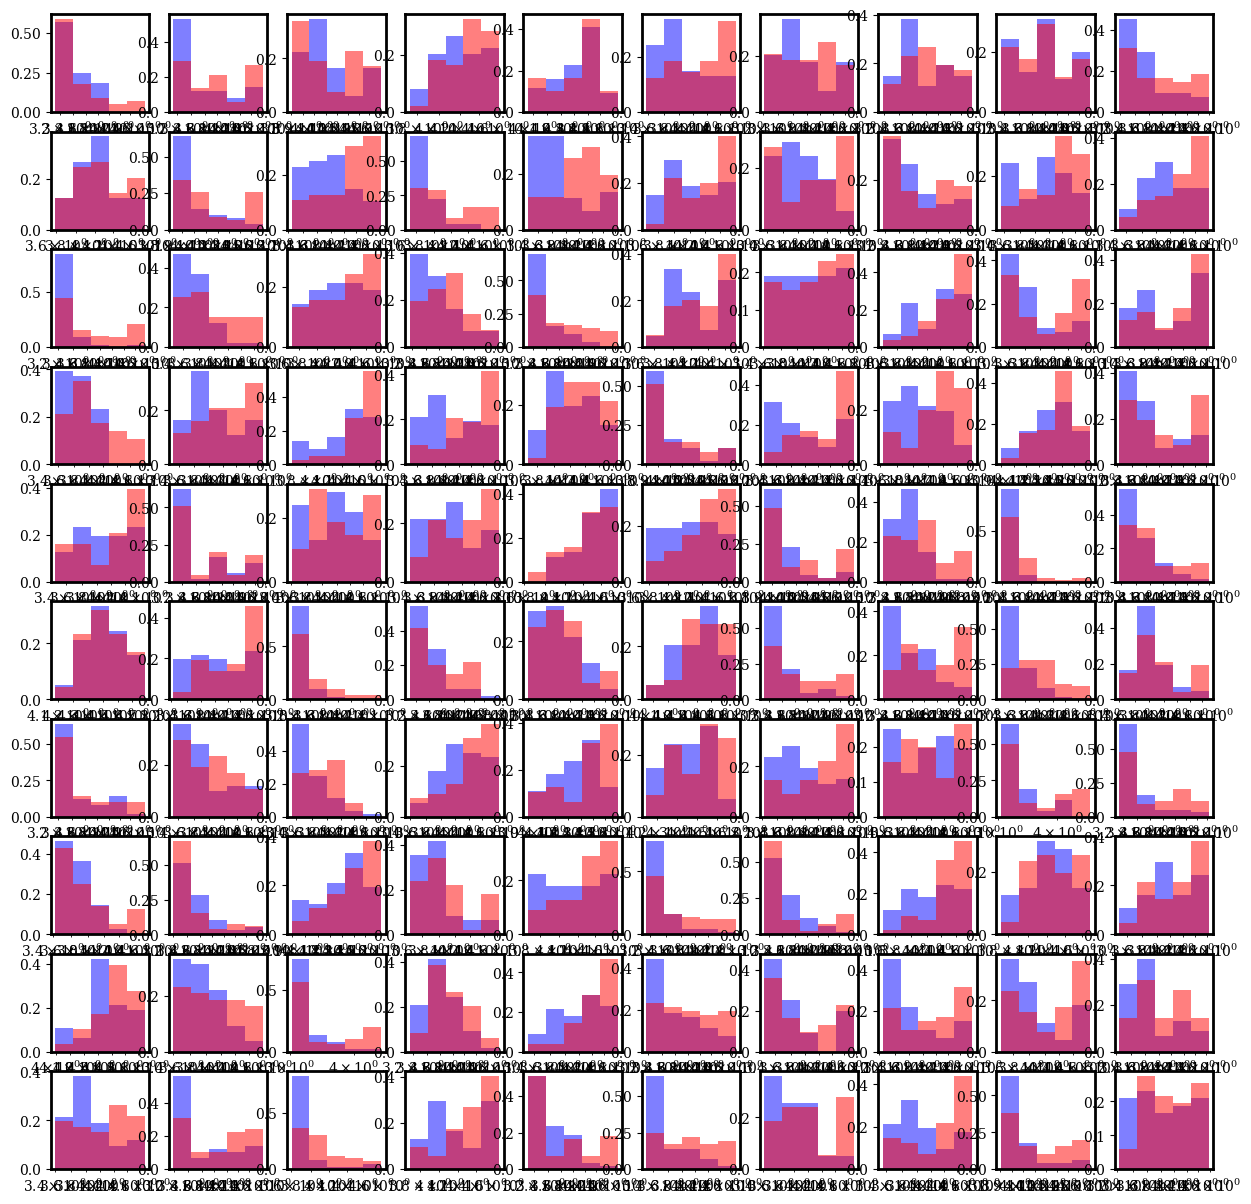

In [88]:

risk_score = calculate_risk_score(MIA.s_tr_m_entr, MIA.s_te_m_entr, MIA.s_tr_labels, MIA.s_te_labels, MIA.t_tr_m_entr, MIA.t_tr_labels)